# Build and train image-genomin-coding

* Refer to CMC: https://github.com/HobbitLong/CMC/blob/master/train_CMC.py

* Refer to InceptionV3: https://pytorch.org/hub/pytorch_vision_inception_v3/

* Refer to more pretrained nets: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [1]:
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import pandas as pd
import re
import sys

import skimage
import skimage.io
import tifffile

import time
import torch
import torch.hub
import torch.nn
# import torchvision.models  # does not work

# Self-defined functions
from alias_multinomial import AliasMethod

## 1) Load data

(25233, 27452, 3)


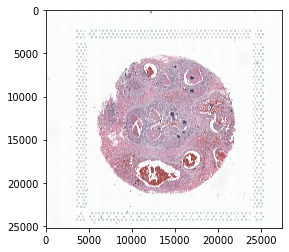

In [2]:
count_stat = pd.read_csv("../data/1_count_stat_breast_cancer_FFPE.csv", index_col=0)
count = pd.read_csv("../data/1_pd_count_norm_breast_cancer_FFPE.csv", index_col=0)

image_file = "/project/shared/xiao_wang/projects/MOCCA/data/Sprod_ready_data/visium/BRCA_ductal/" + \
            "Visium_FFPE_Human_Breast_Cancer_image.tif"
image = tifffile.imread(os.path.join(image_file))
print(image.shape)
image_norm = image.copy()
plt.imshow(image_norm)
plt.show()

In [3]:
transformation_file = "/project/shared/xiao_wang/projects/MOCCA/data/Sprod_ready_data/visium/BRCA_ductal/" + \
                      "Spot_metadata.csv"
pd_meta = pd.read_table(transformation_file, index_col=0, sep=",")
print(pd_meta.shape)
print(count.shape)

(2518, 5)
(2518, 17649)


In [4]:
# Split training and testing
np.random.seed(82321)
indexes_all = pd_meta.index.values
training_indexes = np.random.choice(indexes_all, int(len(indexes_all) * 0.8), replace=False)
testing_indexes = [_ for _ in indexes_all if _ not in training_indexes]
print("#Training: {}, #Testing: {}".format(len(training_indexes), len(testing_indexes)))
training_indexes.sort()
testing_indexes.sort()

#Training: 2014, #Testing: 504


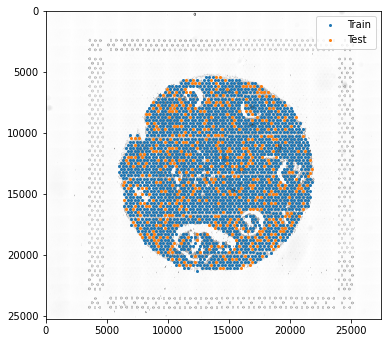

In [5]:
# Plot training & testing distribution
plt.figure(figsize=(6, 6))
plt.imshow(image_norm[..., 0], cmap="gray")
coords_x = pd_meta.loc[training_indexes, "Y"].values
coords_y = pd_meta.loc[training_indexes, "X"].values
plt.scatter(coords_x, coords_y, s=4, label="Train")
coords_x = pd_meta.loc[testing_indexes, "Y"].values
coords_y = pd_meta.loc[testing_indexes, "X"].values
plt.scatter(coords_x, coords_y, s=4, label="Test")
plt.gca().set_aspect('equal')
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.legend()
plt.show()

In [6]:
# Log2
count = np.log2(count + 1)

# Normalize gene_stat by divided with max
count_max = np.log2(count_stat.loc['max', :].values + 1)
count_max[count_max < 1] = 1
count = count/count_max

In [7]:
count

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
GTAGACAACCGATGAA-1,0.0,0.0,0.761631,0.0,0.0,0.000000,0.0,0.744482,0.0,0.0,...,0.726320,0.0,0.0,0.0,0.0,0.000000,0.659402,0.000000,0.561415,0.766887
ACAGATTAGGTTAGTG-1,0.0,0.0,0.777500,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.790607,0.0,0.0,0.0,0.0,0.000000,0.000000,0.760919,0.611106,0.726753
TGGTATCGGTCTGTAT-1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
ATTATCTCGACAGATC-1,0.0,0.0,0.677931,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
TGAGATCAAATACTCA-1,0.0,0.0,0.737967,0.0,0.0,0.797309,0.0,0.000000,0.0,0.0,...,0.805059,0.0,0.0,0.0,0.0,0.000000,0.000000,0.774829,0.705950,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCCCTGAGGATGGGCT-1,0.0,0.0,0.731573,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.797171,0.0,0.0,0.0,0.0,0.766232,0.000000,0.000000,0.000000,0.732786
CGGGCGATGGATCACG-1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.809787,0.000000
TGCGGACTTGACTCCG-1,0.0,0.0,0.733408,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.785434,0.000000
TCGCTGCCAATGCTGT-1,0.0,0.0,0.904212,0.0,0.0,0.000000,0.0,0.924557,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.830139,0.000000


In [8]:
PATCH_SIZE = 256

## 2) Check data loader

In [9]:
# from utils_data import Dataset
from utils_data import normalize, augmentor

import numpy as np
import math
import skimage
import skimage.transform

import torch
import torch.utils
import torch.utils.data
    
# Get image patch
def get_image_patch(image, coords, patch_size):
    """
    Args:
        coords: center of image; x, y (col, row) in pixels
    """
    row_start = int(coords[1] - patch_size/2)
    col_start = int(coords[0] - patch_size/2)
    return image[row_start:row_start + patch_size, col_start:col_start + patch_size]

class Dataset(torch.utils.data.Dataset):
    __initialized = False
    def __init__(self, indexes, image, count_df, meta_df, augmentation=False):
        """
        Args:
            indexes: index used for both count_df and meta_df
        """
        self.indexes = indexes
        self.image = image
        self.count_df = count_df
        self.meta_df = meta_df
        self.augmentation = augmentation
        self.__initialized = True

    def __len__(self):
        """Denotes the number of samples"""
        return len(self.indexes)
    
    def __getitem__(self, index):
        """Generate one batch of data.
        
        Returns:
            index: indexes of samples (long)
        """
        # Generate data
        data = self.__data_generation(self.indexes[index])

        return data, index
    
    def __data_generation(self, indexes):
        """Generates data containing batch_size samples.
        
        Returns:
            data: a dictionary with data.image in [b, ch, h, w]; data.gene in [b, n_genes]
        """
        image = get_image_patch(self.image, 
                                [self.meta_df.loc[indexes, "Y"], self.meta_df.loc[indexes, "X"]], 
                                PATCH_SIZE)  # meta_df mistakes X/Y
        if self.augmentation:
            image = augmentor(normalize(image))
        else:
            image = normalize(image)
        
        data = dict()
        data['image'] = torch.tensor(np.transpose(image, (2, 0, 1)).astype(float))
        data['gene'] = torch.tensor(self.count_df.loc[indexes, :].values)
        
        return data 

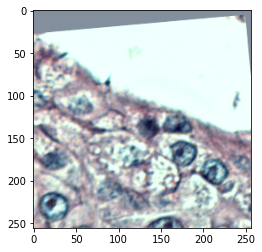

tensor([404])


In [10]:
# Generator
np.random.seed()
train_set = Dataset(training_indexes, image_norm, count, pd_meta, augmentation=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=1)
for x, y in train_loader:
    plt.imshow(normalize(np.transpose(x['image'][0].numpy(), (1, 2, 0)), inverse=True))
    plt.show()
    print(y)
    break

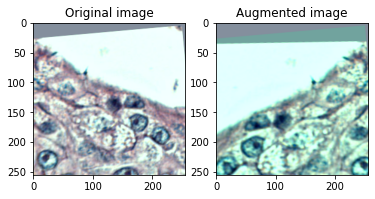

In [11]:
image = normalize(np.transpose(x['image'][0].numpy(), (1, 2, 0)), inverse=True)
plt.subplot(121)
plt.imshow(image)
plt.title("Original image")
plt.subplot(122)
plt.imshow(normalize(augmentor(normalize(image)), inverse=True))
plt.title("Augmented image")
plt.show()

## 3) Create network

In [12]:
class IGCNet(torch.nn.Module):
    def __init__(self, image_shape, n_genes, n_out_features, 
                 imagenet='resnet101', 
                 genenet=[500, 100]):
        """
        Args:
            image_shape: w/h of input image
            n_genes: number of genes to consider
            n_out_features: number of output features
            imagenet: architecture to encode image features
            genenet: architecture to encode genetic features: list of #hidden nodes
        """
        super(IGCNet, self).__init__()

        if imagenet == 'resnet101':
            # Require image size at least 224
            self.imagenet = torch.hub.load('pytorch/vision:v0.4.0', imagenet, pretrained=True)
            self.imagenet.float()
            self.imagenet.layer4[2].relu = torch.nn.ReLU6()
            self.imagenet.fc = torch.nn.Linear(self.imagenet.fc.in_features, n_out_features)
            input_size = image_shape
        elif imagenet == 'inception_v3':
            # Require image input size = 299, has auxillary output
            self.imagenet = torch.hub.load('pytorch/vision:v0.4.0', imagenet, pretrained=True)
            self.imagenet.float()
            raise("Incomplete model")
        else:
            raise("Invalid model name")

        genenet_fcs = []
        genenet_in_shape = n_genes
        for i, genenet_n_hidden_nodes in enumerate(genenet):
            genenet_fcs.append(torch.nn.Linear(genenet_in_shape, genenet_n_hidden_nodes))
            genenet_fcs.append(torch.nn.BatchNorm1d(genenet_n_hidden_nodes))
            genenet_fcs.append(torch.nn.ReLU6())
            genenet_in_shape = genenet_n_hidden_nodes
        genenet_fcs.append(torch.nn.Linear(genenet_in_shape, n_out_features))
        self.genenet_fcs = torch.nn.ModuleList(genenet_fcs)

    def forward(self, data):
        """
        Args:
            data: a dictionary
        """
        image, gene = data['image'], data['gene']
        f_image = self.imagenet(image)
        
        f_gene = gene
        for layer in self.genenet_fcs:
            f_gene = layer(f_gene)
        
        return f_image, f_gene

In [13]:
from torch.nn.modules import MSELoss
from utils_eval import NCESoftmaxLoss, NCECriterion
# from IGCmodel import IGCNet, NCEAverage
from IGCmodel import NCEAverage

device = torch.device("cuda:1")
image_shape = PATCH_SIZE
n_genes = count_stat.shape[1]
n_data = len(training_indexes)
n_out_features = 100
imagenet = 'resnet101'

# NCE parameters
# Increasing nce_m improves stability
# !!! Adding batch normalization layer improves stability 
nce_k = 100
nce_t = 0.07
nce_m = 0.9
softmax = False

# Training parameters
# Decreasing lr and adding gradient_clip improves stability
lr = 0.01   # ori 0.01
momentum = 0.9
weight_decay = 0.0001
gradient_clip = 5

# Generator
train_set = Dataset(training_indexes, image_norm, count, pd_meta, augmentation=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=20, shuffle=True, num_workers=1)
test_set = Dataset(testing_indexes, image_norm, count, pd_meta, augmentation=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=20, shuffle=False, num_workers=1)

# Set model
model = IGCNet(image_shape=image_shape, n_genes=n_genes, n_out_features=n_out_features, 
               imagenet=imagenet, genenet=[500, 100]).to(device)
contrast = NCEAverage(n_out_features, n_data, nce_k, nce_t, nce_m, softmax, device=device).to(device)
criterion_image = NCESoftmaxLoss().to(device) if softmax else NCECriterion(n_data).to(device)
criterion_gene = NCESoftmaxLoss().to(device) if softmax else NCECriterion(n_data).to(device)

# Set optimizer
optimizer = torch.optim.SGD(model.parameters(),
                            lr=lr,
                            momentum=momentum,
                            weight_decay=weight_decay)

Using cache found in /home2/swan15/.cache/torch/hub/pytorch_vision_v0.4.0


In [14]:
model_dir = "./models/2_IGC_breast_cancer_FFPE"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [15]:
model

IGCNet(
  (imagenet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [16]:
"""TO LOAD:"""
model_file = None
if model_file is not None:
    print("=> loading checkpoint '{}'".format(model_file))
    checkpoint = torch.load(model_file, map_location=device)
    start_epoch = checkpoint['epoch'] + 1
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    contrast.load_state_dict(checkpoint['contrast'])
    del checkpoint

## 4) Train

In [17]:
import time
from scipy.stats import spearmanr

from utils_eval import AverageMeter

def train(epoch, train_loader, model, contrast, criterion_image, criterion_gene, optimizer, 
          gradient_clip=10, print_freq=1, device=torch.device("cuda:0")):
    """
    One epoch training
    """
    model.train()
    contrast.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    image_loss_meter = AverageMeter()
    gene_loss_meter = AverageMeter()
    image_prob_meter = AverageMeter()
    gene_prob_meter = AverageMeter()

    end = time.time()
    for idx, (data, index) in enumerate(train_loader):
        data_time.update(time.time() - end)

        batch_size = data['image'].size(0)
        index = index.to(device)
        for _ in data.keys():
            data[_] = data[_].float().to(device)

        # ===================forward=====================
        feat_image, feat_gene = model(data)
        out_image, out_gene = contrast(feat_image, feat_gene, index)
        
        # print("features:", feat_image, feat_gene, "\n")
        # print("outs: ", out_image, out_gene, "\n")
        
        image_loss = criterion_image(out_image)
        gene_loss = criterion_gene(out_gene)
        image_prob = out_image[:, 0].mean()
        gene_prob = out_gene[:, 0].mean()

        loss = image_loss + gene_loss

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
        torch.nn.utils.clip_grad_norm_(contrast.parameters(), gradient_clip)
        optimizer.step()

        # ===================meters=====================
        losses.update(loss.item(), batch_size)
        image_loss_meter.update(image_loss.item(), batch_size)
        image_prob_meter.update(image_prob.item(), batch_size)
        gene_loss_meter.update(gene_loss.item(), batch_size)
        gene_prob_meter.update(gene_prob.item(), batch_size)

        torch.cuda.synchronize()
        batch_time.update(time.time() - end)
        end = time.time()

        # print info
        if (idx + 1) % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  # 'BT {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  # 'DT {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'loss {loss.val:.3f} ({loss.avg:.3f})\t'
                  'image_p {image_probs.val:.3f} ({image_probs.avg:.3f})\t'
                  'gene_p {gene_probs.val:.3f} ({gene_probs.avg:.3f})'.format(
                   epoch, idx + 1, len(train_loader), batch_time=batch_time,
                   data_time=data_time, 
                   loss=losses, 
                   image_probs=image_prob_meter,
                   gene_probs=gene_prob_meter))
            # print(out_image.shape)
            sys.stdout.flush()
            
        # ===================debug======================
        if np.isnan(image_prob_meter.val):
            print(list(model.parameters()))
            print(feat_image)
            print(feat_gene)
            print(out_image)
            
            raise Exception("Nan detected")
            break

    return losses.avg, image_loss_meter.avg, image_prob_meter.avg, gene_loss_meter.avg, gene_prob_meter.avg


def test(epoch, test_loader, model, contrast, criterion_image, criterion_gene, optimizer, 
          gradient_clip=10, print_freq=1, device=torch.device("cuda:0")):
    """Testing"""
    model.eval()
    contrast.eval()

    batch_time = AverageMeter()
    data_time = AverageMeter()

    end = time.time()
    for idx, (data, index) in enumerate(test_loader):
        data_time.update(time.time() - end)

        batch_size = data['image'].size(0)
        index = index.to(device)
        for _ in data.keys():
            data[_] = data[_].float().to(device)

        # ===================forward=====================
        with torch.no_grad():
            feat_image, feat_gene = model(data)
        
        # Append
        if idx == 0:
            feat_images = feat_image.cpu().numpy()
            feat_genes = feat_gene.cpu().numpy()
        else:
            feat_images = np.concatenate([feat_images, feat_image.cpu().numpy()])
            feat_genes = np.concatenate([feat_genes, feat_gene.cpu().numpy()])
        
        torch.cuda.synchronize()
        batch_time.update(time.time() - end)
        end = time.time()
        
    # Normalize & calculate correlation
    feat_images = feat_images / np.sum(feat_images ** 2, axis=1, keepdims=True) ** 0.5
    feat_genes = feat_genes / np.sum(feat_genes ** 2, axis=1, keepdims=True) ** 0.5
    corr = []
    for i in range(feat_images.shape[1]):
        corr.append(spearmanr(feat_images[:, i], feat_genes[:, i]).correlation)
    if epoch % 100 == 0:
        plt.hist(corr, bins=30)
        plt.show()
    print("Val epoch {}, average corr {}".format(epoch, np.average(corr)))

    return np.average(corr)

Epoch: [0][10/101]	loss 39.612 (39.562)	image_p 0.008 (0.010)	gene_p 0.009 (0.010)
Epoch: [0][20/101]	loss 35.660 (38.904)	image_p 0.005 (0.009)	gene_p 0.014 (0.010)
Epoch: [0][30/101]	loss 34.546 (37.419)	image_p 0.006 (0.010)	gene_p 0.010 (0.010)
Epoch: [0][40/101]	loss 32.969 (36.420)	image_p 0.000 (0.008)	gene_p 0.011 (0.011)
Epoch: [0][50/101]	loss 31.105 (35.441)	image_p 0.001 (0.008)	gene_p 0.020 (0.012)
Epoch: [0][60/101]	loss 28.638 (34.519)	image_p 0.003 (0.010)	gene_p 0.021 (0.013)
Epoch: [0][70/101]	loss 25.229 (33.479)	image_p 0.076 (0.012)	gene_p 0.018 (0.014)
Epoch: [0][80/101]	loss 23.368 (32.438)	image_p 0.055 (0.017)	gene_p 0.031 (0.017)
Epoch: [0][90/101]	loss 19.736 (31.234)	image_p 0.050 (0.022)	gene_p 0.105 (0.022)
Epoch: [0][100/101]	loss 12.665 (29.754)	image_p 0.290 (0.031)	gene_p 0.316 (0.037)


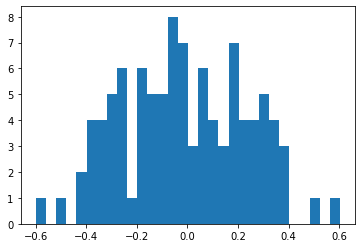

Val epoch 0, average corr -0.011875453549495285
Epoch: [1][10/101]	loss 28.196 (31.389)	image_p 0.007 (0.005)	gene_p 0.002 (0.010)
Epoch: [1][20/101]	loss 29.508 (29.574)	image_p 0.018 (0.010)	gene_p 0.001 (0.013)
Epoch: [1][30/101]	loss 25.423 (28.645)	image_p 0.036 (0.013)	gene_p 0.091 (0.017)
Epoch: [1][40/101]	loss 23.320 (27.641)	image_p 0.001 (0.014)	gene_p 0.060 (0.021)
Epoch: [1][50/101]	loss 20.954 (26.764)	image_p 0.037 (0.016)	gene_p 0.016 (0.024)
Epoch: [1][60/101]	loss 22.648 (26.006)	image_p 0.012 (0.017)	gene_p 0.093 (0.028)
Epoch: [1][70/101]	loss 19.479 (25.306)	image_p 0.007 (0.018)	gene_p 0.137 (0.032)
Epoch: [1][80/101]	loss 19.695 (24.622)	image_p 0.012 (0.022)	gene_p 0.014 (0.033)
Epoch: [1][90/101]	loss 17.716 (23.924)	image_p 0.185 (0.030)	gene_p 0.082 (0.037)
Epoch: [1][100/101]	loss 8.614 (22.907)	image_p 0.505 (0.050)	gene_p 0.499 (0.054)
Val epoch 1, average corr 0.24540446186498308
Epoch: [2][10/101]	loss 29.666 (31.241)	image_p 0.015 (0.019)	gene_p 0.011 (

Epoch: [10][50/101]	loss 21.140 (22.515)	image_p 0.093 (0.066)	gene_p 0.020 (0.062)
Epoch: [10][60/101]	loss 15.992 (21.955)	image_p 0.237 (0.074)	gene_p 0.121 (0.070)
Epoch: [10][70/101]	loss 19.502 (21.575)	image_p 0.110 (0.083)	gene_p 0.081 (0.071)
Epoch: [10][80/101]	loss 13.082 (20.979)	image_p 0.316 (0.095)	gene_p 0.205 (0.079)
Epoch: [10][90/101]	loss 12.837 (20.425)	image_p 0.494 (0.112)	gene_p 0.193 (0.085)
Epoch: [10][100/101]	loss 9.228 (19.698)	image_p 0.726 (0.144)	gene_p 0.254 (0.095)
Val epoch 10, average corr 0.38813149956911425
Saving model...
Epoch: [11][10/101]	loss 24.094 (24.496)	image_p 0.068 (0.064)	gene_p 0.069 (0.068)
Epoch: [11][20/101]	loss 25.913 (24.337)	image_p 0.023 (0.058)	gene_p 0.008 (0.050)
Epoch: [11][30/101]	loss 23.662 (23.936)	image_p 0.046 (0.060)	gene_p 0.017 (0.048)
Epoch: [11][40/101]	loss 25.214 (23.377)	image_p 0.073 (0.071)	gene_p 0.034 (0.045)
Epoch: [11][50/101]	loss 19.359 (22.944)	image_p 0.115 (0.077)	gene_p 0.025 (0.043)
Epoch: [11][6

Epoch: [19][80/101]	loss 14.077 (16.868)	image_p 0.249 (0.179)	gene_p 0.171 (0.130)
Epoch: [19][90/101]	loss 13.169 (16.403)	image_p 0.463 (0.204)	gene_p 0.086 (0.136)
Epoch: [19][100/101]	loss 12.786 (15.806)	image_p 0.760 (0.243)	gene_p 0.219 (0.151)
Val epoch 19, average corr 0.5869333608771891
Epoch: [20][10/101]	loss 17.143 (18.662)	image_p 0.149 (0.120)	gene_p 0.193 (0.103)
Epoch: [20][20/101]	loss 14.067 (18.159)	image_p 0.257 (0.137)	gene_p 0.256 (0.123)
Epoch: [20][30/101]	loss 18.262 (17.948)	image_p 0.059 (0.147)	gene_p 0.142 (0.118)
Epoch: [20][40/101]	loss 17.993 (17.714)	image_p 0.228 (0.154)	gene_p 0.133 (0.124)
Epoch: [20][50/101]	loss 15.103 (17.427)	image_p 0.178 (0.158)	gene_p 0.142 (0.127)
Epoch: [20][60/101]	loss 15.832 (17.116)	image_p 0.336 (0.173)	gene_p 0.098 (0.129)
Epoch: [20][70/101]	loss 14.820 (16.700)	image_p 0.254 (0.190)	gene_p 0.137 (0.135)
Epoch: [20][80/101]	loss 13.106 (16.295)	image_p 0.385 (0.212)	gene_p 0.125 (0.140)
Epoch: [20][90/101]	loss 10.5

Val epoch 28, average corr 0.6573357222642671
Epoch: [29][10/101]	loss 14.922 (15.009)	image_p 0.143 (0.233)	gene_p 0.216 (0.182)
Epoch: [29][20/101]	loss 14.747 (14.624)	image_p 0.250 (0.226)	gene_p 0.200 (0.205)
Epoch: [29][30/101]	loss 12.886 (14.317)	image_p 0.320 (0.236)	gene_p 0.267 (0.205)
Epoch: [29][40/101]	loss 13.453 (14.165)	image_p 0.259 (0.239)	gene_p 0.136 (0.203)
Epoch: [29][50/101]	loss 12.583 (13.844)	image_p 0.283 (0.252)	gene_p 0.265 (0.208)
Epoch: [29][60/101]	loss 12.214 (13.645)	image_p 0.247 (0.265)	gene_p 0.201 (0.208)
Epoch: [29][70/101]	loss 11.809 (13.340)	image_p 0.321 (0.280)	gene_p 0.204 (0.220)
Epoch: [29][80/101]	loss 8.904 (13.053)	image_p 0.586 (0.302)	gene_p 0.389 (0.222)
Epoch: [29][90/101]	loss 8.687 (12.749)	image_p 0.668 (0.330)	gene_p 0.231 (0.228)
Epoch: [29][100/101]	loss 5.234 (12.303)	image_p 0.954 (0.367)	gene_p 0.423 (0.240)
Val epoch 29, average corr 0.6461947941395144
Epoch: [30][10/101]	loss 14.031 (14.176)	image_p 0.231 (0.249)	gene_p 

Epoch: [38][40/101]	loss 14.001 (12.069)	image_p 0.242 (0.346)	gene_p 0.082 (0.254)
Epoch: [38][50/101]	loss 11.358 (11.949)	image_p 0.448 (0.364)	gene_p 0.251 (0.257)
Epoch: [38][60/101]	loss 9.741 (11.739)	image_p 0.442 (0.373)	gene_p 0.282 (0.264)
Epoch: [38][70/101]	loss 9.967 (11.496)	image_p 0.469 (0.383)	gene_p 0.290 (0.268)
Epoch: [38][80/101]	loss 7.900 (11.181)	image_p 0.718 (0.407)	gene_p 0.371 (0.278)
Epoch: [38][90/101]	loss 7.633 (10.747)	image_p 0.704 (0.435)	gene_p 0.299 (0.293)
Epoch: [38][100/101]	loss 4.496 (10.286)	image_p 0.921 (0.470)	gene_p 0.466 (0.314)
Val epoch 38, average corr 0.6101915526191022
Epoch: [39][10/101]	loss 10.575 (11.626)	image_p 0.443 (0.399)	gene_p 0.260 (0.254)
Epoch: [39][20/101]	loss 9.228 (11.362)	image_p 0.404 (0.373)	gene_p 0.398 (0.275)
Epoch: [39][30/101]	loss 10.483 (11.068)	image_p 0.464 (0.386)	gene_p 0.156 (0.279)
Epoch: [39][40/101]	loss 10.753 (10.979)	image_p 0.436 (0.390)	gene_p 0.313 (0.285)
Epoch: [39][50/101]	loss 9.338 (10.

Epoch: [47][80/101]	loss 7.468 (9.421)	image_p 0.635 (0.472)	gene_p 0.274 (0.353)
Epoch: [47][90/101]	loss 7.206 (9.230)	image_p 0.573 (0.484)	gene_p 0.512 (0.363)
Epoch: [47][100/101]	loss 6.750 (8.918)	image_p 0.672 (0.507)	gene_p 0.407 (0.378)
Val epoch 47, average corr 0.648049030466161
Epoch: [48][10/101]	loss 11.956 (10.861)	image_p 0.283 (0.389)	gene_p 0.295 (0.313)
Epoch: [48][20/101]	loss 9.137 (10.523)	image_p 0.465 (0.401)	gene_p 0.378 (0.322)
Epoch: [48][30/101]	loss 10.193 (10.516)	image_p 0.603 (0.413)	gene_p 0.308 (0.319)
Epoch: [48][40/101]	loss 12.592 (10.347)	image_p 0.257 (0.425)	gene_p 0.261 (0.318)
Epoch: [48][50/101]	loss 10.388 (10.263)	image_p 0.393 (0.436)	gene_p 0.255 (0.318)
Epoch: [48][60/101]	loss 11.702 (10.041)	image_p 0.380 (0.452)	gene_p 0.226 (0.320)
Epoch: [48][70/101]	loss 8.985 (9.874)	image_p 0.501 (0.464)	gene_p 0.331 (0.324)
Epoch: [48][80/101]	loss 9.015 (9.758)	image_p 0.467 (0.475)	gene_p 0.276 (0.323)
Epoch: [48][90/101]	loss 7.140 (9.479)	im

Epoch: [57][20/101]	loss 10.746 (9.044)	image_p 0.460 (0.460)	gene_p 0.269 (0.390)
Epoch: [57][30/101]	loss 9.385 (9.099)	image_p 0.499 (0.452)	gene_p 0.473 (0.384)
Epoch: [57][40/101]	loss 10.343 (9.041)	image_p 0.288 (0.446)	gene_p 0.428 (0.381)
Epoch: [57][50/101]	loss 6.372 (8.931)	image_p 0.434 (0.450)	gene_p 0.632 (0.393)
Epoch: [57][60/101]	loss 7.766 (8.762)	image_p 0.537 (0.467)	gene_p 0.481 (0.395)
Epoch: [57][70/101]	loss 9.521 (8.612)	image_p 0.642 (0.478)	gene_p 0.240 (0.409)
Epoch: [57][80/101]	loss 5.719 (8.352)	image_p 0.606 (0.491)	gene_p 0.564 (0.425)
Epoch: [57][90/101]	loss 4.466 (8.170)	image_p 0.803 (0.502)	gene_p 0.613 (0.433)
Epoch: [57][100/101]	loss 4.641 (7.839)	image_p 0.777 (0.523)	gene_p 0.570 (0.453)
Val epoch 57, average corr 0.6128967740000357
Epoch: [58][10/101]	loss 8.888 (9.273)	image_p 0.354 (0.421)	gene_p 0.391 (0.370)
Epoch: [58][20/101]	loss 8.199 (9.110)	image_p 0.398 (0.439)	gene_p 0.460 (0.377)
Epoch: [58][30/101]	loss 8.629 (8.939)	image_p 0.

Epoch: [66][70/101]	loss 7.226 (8.955)	image_p 0.630 (0.428)	gene_p 0.483 (0.423)
Epoch: [66][80/101]	loss 9.438 (8.915)	image_p 0.371 (0.430)	gene_p 0.468 (0.434)
Epoch: [66][90/101]	loss 7.555 (8.765)	image_p 0.489 (0.435)	gene_p 0.461 (0.443)
Epoch: [66][100/101]	loss 5.138 (8.502)	image_p 0.720 (0.448)	gene_p 0.632 (0.462)
Val epoch 66, average corr 0.6473901634709454
Epoch: [67][10/101]	loss 10.166 (8.370)	image_p 0.347 (0.454)	gene_p 0.348 (0.449)
Epoch: [67][20/101]	loss 10.639 (8.562)	image_p 0.454 (0.486)	gene_p 0.251 (0.406)
Epoch: [67][30/101]	loss 9.336 (8.597)	image_p 0.386 (0.488)	gene_p 0.331 (0.402)
Epoch: [67][40/101]	loss 8.014 (8.691)	image_p 0.552 (0.485)	gene_p 0.377 (0.394)
Epoch: [67][50/101]	loss 9.127 (8.478)	image_p 0.549 (0.492)	gene_p 0.306 (0.406)
Epoch: [67][60/101]	loss 8.709 (8.378)	image_p 0.557 (0.500)	gene_p 0.280 (0.405)
Epoch: [67][70/101]	loss 8.412 (8.357)	image_p 0.475 (0.499)	gene_p 0.423 (0.409)
Epoch: [67][80/101]	loss 8.169 (8.165)	image_p 0.

Epoch: [76][10/101]	loss 6.551 (8.169)	image_p 0.647 (0.523)	gene_p 0.423 (0.382)
Epoch: [76][20/101]	loss 7.248 (8.344)	image_p 0.656 (0.517)	gene_p 0.399 (0.394)
Epoch: [76][30/101]	loss 8.459 (8.253)	image_p 0.683 (0.523)	gene_p 0.323 (0.396)
Epoch: [76][40/101]	loss 6.977 (8.321)	image_p 0.663 (0.527)	gene_p 0.433 (0.397)
Epoch: [76][50/101]	loss 9.185 (8.082)	image_p 0.616 (0.544)	gene_p 0.343 (0.402)
Epoch: [76][60/101]	loss 5.422 (7.854)	image_p 0.716 (0.556)	gene_p 0.521 (0.421)
Epoch: [76][70/101]	loss 4.894 (7.696)	image_p 0.650 (0.563)	gene_p 0.570 (0.431)
Epoch: [76][80/101]	loss 6.708 (7.454)	image_p 0.707 (0.578)	gene_p 0.494 (0.444)
Epoch: [76][90/101]	loss 4.198 (7.223)	image_p 0.881 (0.590)	gene_p 0.524 (0.460)
Epoch: [76][100/101]	loss 5.713 (6.934)	image_p 0.606 (0.610)	gene_p 0.595 (0.478)
Val epoch 76, average corr 0.6739571728907072
Epoch: [77][10/101]	loss 9.787 (8.602)	image_p 0.267 (0.518)	gene_p 0.411 (0.409)
Epoch: [77][20/101]	loss 8.210 (8.284)	image_p 0.55

Epoch: [85][60/101]	loss 4.728 (6.634)	image_p 0.711 (0.598)	gene_p 0.542 (0.524)
Epoch: [85][70/101]	loss 5.261 (6.435)	image_p 0.680 (0.602)	gene_p 0.665 (0.543)
Epoch: [85][80/101]	loss 7.092 (6.323)	image_p 0.565 (0.607)	gene_p 0.531 (0.551)
Epoch: [85][90/101]	loss 3.618 (6.108)	image_p 0.803 (0.618)	gene_p 0.744 (0.565)
Epoch: [85][100/101]	loss 2.314 (5.876)	image_p 0.769 (0.628)	gene_p 0.868 (0.582)
Val epoch 85, average corr 0.6671856164726115
Epoch: [86][10/101]	loss 7.025 (7.239)	image_p 0.596 (0.548)	gene_p 0.481 (0.514)
Epoch: [86][20/101]	loss 7.328 (6.897)	image_p 0.634 (0.568)	gene_p 0.496 (0.513)
Epoch: [86][30/101]	loss 7.569 (6.923)	image_p 0.471 (0.564)	gene_p 0.456 (0.520)
Epoch: [86][40/101]	loss 5.416 (6.893)	image_p 0.664 (0.572)	gene_p 0.561 (0.518)
Epoch: [86][50/101]	loss 6.726 (6.809)	image_p 0.530 (0.575)	gene_p 0.541 (0.527)
Epoch: [86][60/101]	loss 9.379 (6.780)	image_p 0.559 (0.585)	gene_p 0.260 (0.527)
Epoch: [86][70/101]	loss 8.777 (6.658)	image_p 0.52

Val epoch 94, average corr 0.6445635868707824
Epoch: [95][10/101]	loss 7.865 (6.253)	image_p 0.479 (0.568)	gene_p 0.457 (0.581)
Epoch: [95][20/101]	loss 6.281 (6.342)	image_p 0.558 (0.570)	gene_p 0.567 (0.559)
Epoch: [95][30/101]	loss 5.465 (6.261)	image_p 0.669 (0.576)	gene_p 0.619 (0.563)
Epoch: [95][40/101]	loss 6.707 (6.244)	image_p 0.476 (0.576)	gene_p 0.528 (0.565)
Epoch: [95][50/101]	loss 5.648 (6.236)	image_p 0.696 (0.578)	gene_p 0.571 (0.563)
Epoch: [95][60/101]	loss 6.253 (6.140)	image_p 0.523 (0.579)	gene_p 0.569 (0.573)
Epoch: [95][70/101]	loss 6.057 (6.152)	image_p 0.581 (0.580)	gene_p 0.534 (0.571)
Epoch: [95][80/101]	loss 8.476 (6.053)	image_p 0.428 (0.584)	gene_p 0.480 (0.580)
Epoch: [95][90/101]	loss 3.327 (5.883)	image_p 0.808 (0.597)	gene_p 0.719 (0.590)
Epoch: [95][100/101]	loss 3.564 (5.726)	image_p 0.769 (0.607)	gene_p 0.764 (0.604)
Val epoch 95, average corr 0.6536692208840313
Epoch: [96][10/101]	loss 6.690 (6.489)	image_p 0.514 (0.574)	gene_p 0.553 (0.540)
Epoch

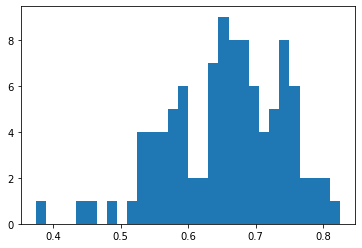

Val epoch 100, average corr 0.6561849668202983
Saving model...
Epoch: [101][10/101]	loss 6.010 (5.250)	image_p 0.568 (0.656)	gene_p 0.597 (0.611)
Epoch: [101][20/101]	loss 5.452 (5.649)	image_p 0.684 (0.632)	gene_p 0.560 (0.580)
Epoch: [101][30/101]	loss 7.516 (5.591)	image_p 0.569 (0.641)	gene_p 0.423 (0.580)
Epoch: [101][40/101]	loss 7.263 (5.491)	image_p 0.530 (0.646)	gene_p 0.514 (0.595)
Epoch: [101][50/101]	loss 4.978 (5.539)	image_p 0.662 (0.640)	gene_p 0.650 (0.593)
Epoch: [101][60/101]	loss 4.430 (5.424)	image_p 0.782 (0.646)	gene_p 0.595 (0.597)
Epoch: [101][70/101]	loss 4.261 (5.365)	image_p 0.750 (0.649)	gene_p 0.659 (0.601)
Epoch: [101][80/101]	loss 3.900 (5.294)	image_p 0.755 (0.651)	gene_p 0.657 (0.610)
Epoch: [101][90/101]	loss 6.091 (5.173)	image_p 0.595 (0.657)	gene_p 0.553 (0.619)
Epoch: [101][100/101]	loss 3.017 (4.978)	image_p 0.841 (0.671)	gene_p 0.775 (0.633)
Val epoch 101, average corr 0.6497794674468029
Epoch: [102][10/101]	loss 6.841 (6.364)	image_p 0.612 (0.54

Epoch: [110][40/101]	loss 5.119 (5.758)	image_p 0.624 (0.628)	gene_p 0.634 (0.567)
Epoch: [110][50/101]	loss 6.576 (5.694)	image_p 0.580 (0.640)	gene_p 0.568 (0.572)
Epoch: [110][60/101]	loss 5.139 (5.559)	image_p 0.685 (0.649)	gene_p 0.533 (0.578)
Epoch: [110][70/101]	loss 3.146 (5.386)	image_p 0.822 (0.660)	gene_p 0.764 (0.591)
Epoch: [110][80/101]	loss 3.179 (5.258)	image_p 0.760 (0.670)	gene_p 0.768 (0.601)
Epoch: [110][90/101]	loss 3.419 (5.075)	image_p 0.755 (0.682)	gene_p 0.745 (0.614)
Epoch: [110][100/101]	loss 2.528 (4.798)	image_p 0.877 (0.701)	gene_p 0.784 (0.634)
Val epoch 110, average corr 0.6487931863031696
Saving model...
Epoch: [111][10/101]	loss 5.885 (6.267)	image_p 0.642 (0.609)	gene_p 0.566 (0.536)
Epoch: [111][20/101]	loss 6.723 (6.062)	image_p 0.655 (0.601)	gene_p 0.471 (0.565)
Epoch: [111][30/101]	loss 5.539 (5.809)	image_p 0.612 (0.630)	gene_p 0.568 (0.575)
Epoch: [111][40/101]	loss 3.938 (5.723)	image_p 0.738 (0.642)	gene_p 0.732 (0.576)
Epoch: [111][50/101]	lo

Epoch: [119][80/101]	loss 2.834 (4.225)	image_p 0.760 (0.713)	gene_p 0.819 (0.701)
Epoch: [119][90/101]	loss 3.294 (4.069)	image_p 0.757 (0.721)	gene_p 0.779 (0.714)
Epoch: [119][100/101]	loss 1.451 (3.837)	image_p 0.871 (0.737)	gene_p 0.933 (0.731)
Val epoch 119, average corr 0.6463353732722475
Epoch: [120][10/101]	loss 4.074 (5.093)	image_p 0.786 (0.669)	gene_p 0.630 (0.631)
Epoch: [120][20/101]	loss 3.855 (4.938)	image_p 0.778 (0.680)	gene_p 0.626 (0.629)
Epoch: [120][30/101]	loss 4.877 (4.799)	image_p 0.695 (0.694)	gene_p 0.648 (0.638)
Epoch: [120][40/101]	loss 2.094 (4.734)	image_p 0.876 (0.696)	gene_p 0.876 (0.650)
Epoch: [120][50/101]	loss 6.157 (4.697)	image_p 0.415 (0.686)	gene_p 0.607 (0.659)
Epoch: [120][60/101]	loss 4.093 (4.624)	image_p 0.770 (0.689)	gene_p 0.702 (0.673)
Epoch: [120][70/101]	loss 3.787 (4.506)	image_p 0.667 (0.696)	gene_p 0.748 (0.685)
Epoch: [120][80/101]	loss 2.884 (4.472)	image_p 0.731 (0.692)	gene_p 0.876 (0.693)
Epoch: [120][90/101]	loss 3.068 (4.321)

Epoch: [129][10/101]	loss 6.909 (5.129)	image_p 0.576 (0.663)	gene_p 0.451 (0.608)
Epoch: [129][20/101]	loss 4.413 (5.079)	image_p 0.640 (0.650)	gene_p 0.697 (0.628)
Epoch: [129][30/101]	loss 3.496 (4.907)	image_p 0.876 (0.670)	gene_p 0.668 (0.634)
Epoch: [129][40/101]	loss 5.308 (4.702)	image_p 0.696 (0.679)	gene_p 0.605 (0.652)
Epoch: [129][50/101]	loss 4.024 (4.606)	image_p 0.667 (0.686)	gene_p 0.753 (0.657)
Epoch: [129][60/101]	loss 3.362 (4.579)	image_p 0.841 (0.695)	gene_p 0.685 (0.659)
Epoch: [129][70/101]	loss 2.551 (4.484)	image_p 0.795 (0.703)	gene_p 0.825 (0.665)
Epoch: [129][80/101]	loss 1.439 (4.328)	image_p 0.895 (0.715)	gene_p 0.878 (0.675)
Epoch: [129][90/101]	loss 1.980 (4.145)	image_p 0.913 (0.730)	gene_p 0.834 (0.688)
Epoch: [129][100/101]	loss 3.357 (3.967)	image_p 0.727 (0.743)	gene_p 0.869 (0.701)
Val epoch 129, average corr 0.6537986394272306
Epoch: [130][10/101]	loss 4.663 (4.817)	image_p 0.660 (0.696)	gene_p 0.675 (0.638)
Epoch: [130][20/101]	loss 4.699 (4.982)

Epoch: [138][50/101]	loss 2.388 (4.739)	image_p 0.869 (0.682)	gene_p 0.841 (0.650)
Epoch: [138][60/101]	loss 4.037 (4.557)	image_p 0.777 (0.697)	gene_p 0.623 (0.660)
Epoch: [138][70/101]	loss 4.380 (4.417)	image_p 0.793 (0.710)	gene_p 0.631 (0.668)
Epoch: [138][80/101]	loss 3.715 (4.312)	image_p 0.785 (0.721)	gene_p 0.688 (0.673)
Epoch: [138][90/101]	loss 2.232 (4.165)	image_p 0.899 (0.732)	gene_p 0.810 (0.682)
Epoch: [138][100/101]	loss 2.319 (3.970)	image_p 0.831 (0.747)	gene_p 0.784 (0.696)
Val epoch 138, average corr 0.6367609564624221
Epoch: [139][10/101]	loss 4.195 (4.970)	image_p 0.658 (0.671)	gene_p 0.695 (0.646)
Epoch: [139][20/101]	loss 4.182 (5.185)	image_p 0.676 (0.649)	gene_p 0.726 (0.629)
Epoch: [139][30/101]	loss 5.192 (5.207)	image_p 0.748 (0.645)	gene_p 0.641 (0.629)
Epoch: [139][40/101]	loss 5.617 (5.002)	image_p 0.718 (0.668)	gene_p 0.583 (0.639)
Epoch: [139][50/101]	loss 5.470 (5.034)	image_p 0.734 (0.666)	gene_p 0.543 (0.636)
Epoch: [139][60/101]	loss 4.329 (5.022)

Epoch: [147][90/101]	loss 2.446 (3.549)	image_p 0.807 (0.742)	gene_p 0.822 (0.762)
Epoch: [147][100/101]	loss 2.761 (3.459)	image_p 0.733 (0.744)	gene_p 0.879 (0.772)
Val epoch 147, average corr 0.6538765464731648
Epoch: [148][10/101]	loss 6.343 (4.628)	image_p 0.550 (0.718)	gene_p 0.611 (0.635)
Epoch: [148][20/101]	loss 4.911 (4.237)	image_p 0.705 (0.738)	gene_p 0.625 (0.661)
Epoch: [148][30/101]	loss 3.560 (3.928)	image_p 0.844 (0.748)	gene_p 0.648 (0.696)
Epoch: [148][40/101]	loss 3.935 (4.011)	image_p 0.625 (0.728)	gene_p 0.794 (0.702)
Epoch: [148][50/101]	loss 3.484 (3.862)	image_p 0.780 (0.739)	gene_p 0.716 (0.717)
Epoch: [148][60/101]	loss 3.682 (3.784)	image_p 0.723 (0.745)	gene_p 0.725 (0.721)
Epoch: [148][70/101]	loss 3.154 (3.660)	image_p 0.748 (0.752)	gene_p 0.851 (0.731)
Epoch: [148][80/101]	loss 3.253 (3.610)	image_p 0.827 (0.756)	gene_p 0.696 (0.735)
Epoch: [148][90/101]	loss 2.622 (3.478)	image_p 0.840 (0.766)	gene_p 0.823 (0.747)
Epoch: [148][100/101]	loss 1.208 (3.354

Epoch: [157][20/101]	loss 1.960 (3.430)	image_p 0.879 (0.767)	gene_p 0.850 (0.720)
Epoch: [157][30/101]	loss 3.126 (3.639)	image_p 0.760 (0.755)	gene_p 0.859 (0.712)
Epoch: [157][40/101]	loss 1.993 (3.658)	image_p 0.890 (0.755)	gene_p 0.863 (0.716)
Epoch: [157][50/101]	loss 3.874 (3.586)	image_p 0.723 (0.760)	gene_p 0.725 (0.725)
Epoch: [157][60/101]	loss 4.163 (3.512)	image_p 0.805 (0.764)	gene_p 0.619 (0.734)
Epoch: [157][70/101]	loss 3.819 (3.454)	image_p 0.645 (0.765)	gene_p 0.797 (0.740)
Epoch: [157][80/101]	loss 2.177 (3.343)	image_p 0.920 (0.777)	gene_p 0.803 (0.747)
Epoch: [157][90/101]	loss 1.489 (3.240)	image_p 0.864 (0.786)	gene_p 0.960 (0.756)
Epoch: [157][100/101]	loss 1.725 (3.118)	image_p 0.921 (0.794)	gene_p 0.897 (0.766)
Val epoch 157, average corr 0.6539956391528867
Epoch: [158][10/101]	loss 5.819 (4.005)	image_p 0.750 (0.745)	gene_p 0.457 (0.686)
Epoch: [158][20/101]	loss 4.100 (4.084)	image_p 0.642 (0.724)	gene_p 0.706 (0.700)
Epoch: [158][30/101]	loss 3.533 (3.901)

Epoch: [166][60/101]	loss 3.585 (3.767)	image_p 0.829 (0.758)	gene_p 0.681 (0.723)
Epoch: [166][70/101]	loss 2.088 (3.685)	image_p 0.947 (0.768)	gene_p 0.791 (0.725)
Epoch: [166][80/101]	loss 2.171 (3.656)	image_p 0.863 (0.772)	gene_p 0.844 (0.725)
Epoch: [166][90/101]	loss 2.130 (3.572)	image_p 0.906 (0.781)	gene_p 0.790 (0.730)
Epoch: [166][100/101]	loss 1.655 (3.442)	image_p 0.953 (0.792)	gene_p 0.832 (0.738)
Val epoch 166, average corr 0.6275884349239216
Epoch: [167][10/101]	loss 3.270 (4.258)	image_p 0.882 (0.714)	gene_p 0.664 (0.671)
Epoch: [167][20/101]	loss 4.307 (4.200)	image_p 0.721 (0.730)	gene_p 0.695 (0.685)
Epoch: [167][30/101]	loss 2.754 (3.994)	image_p 0.814 (0.750)	gene_p 0.771 (0.701)
Epoch: [167][40/101]	loss 4.773 (3.990)	image_p 0.642 (0.748)	gene_p 0.644 (0.697)
Epoch: [167][50/101]	loss 3.524 (3.937)	image_p 0.804 (0.749)	gene_p 0.749 (0.701)
Epoch: [167][60/101]	loss 3.676 (3.971)	image_p 0.806 (0.750)	gene_p 0.678 (0.694)
Epoch: [167][70/101]	loss 6.595 (3.981)

Epoch: [175][100/101]	loss 2.343 (3.962)	image_p 0.851 (0.763)	gene_p 0.803 (0.684)
Val epoch 175, average corr 0.6239362962593648
Epoch: [176][10/101]	loss 5.973 (4.286)	image_p 0.711 (0.691)	gene_p 0.465 (0.716)
Epoch: [176][20/101]	loss 4.252 (4.071)	image_p 0.619 (0.698)	gene_p 0.778 (0.738)
Epoch: [176][30/101]	loss 3.221 (3.927)	image_p 0.834 (0.718)	gene_p 0.700 (0.725)
Epoch: [176][40/101]	loss 1.572 (3.820)	image_p 0.906 (0.728)	gene_p 0.903 (0.728)
Epoch: [176][50/101]	loss 4.245 (3.823)	image_p 0.728 (0.731)	gene_p 0.564 (0.725)
Epoch: [176][60/101]	loss 3.792 (3.701)	image_p 0.794 (0.742)	gene_p 0.683 (0.734)
Epoch: [176][70/101]	loss 2.591 (3.591)	image_p 0.821 (0.753)	gene_p 0.795 (0.738)
Epoch: [176][80/101]	loss 1.293 (3.487)	image_p 0.971 (0.761)	gene_p 0.885 (0.745)
Epoch: [176][90/101]	loss 2.289 (3.382)	image_p 0.940 (0.771)	gene_p 0.708 (0.750)
Epoch: [176][100/101]	loss 0.946 (3.239)	image_p 0.983 (0.784)	gene_p 0.937 (0.759)
Val epoch 176, average corr 0.62996439

Epoch: [185][30/101]	loss 3.865 (3.556)	image_p 0.767 (0.762)	gene_p 0.661 (0.739)
Epoch: [185][40/101]	loss 2.003 (3.492)	image_p 0.866 (0.762)	gene_p 0.852 (0.746)
Epoch: [185][50/101]	loss 2.944 (3.391)	image_p 0.800 (0.771)	gene_p 0.840 (0.755)
Epoch: [185][60/101]	loss 2.678 (3.365)	image_p 0.823 (0.767)	gene_p 0.744 (0.757)
Epoch: [185][70/101]	loss 2.683 (3.297)	image_p 0.764 (0.772)	gene_p 0.837 (0.762)
Epoch: [185][80/101]	loss 2.264 (3.204)	image_p 0.852 (0.778)	gene_p 0.869 (0.769)
Epoch: [185][90/101]	loss 0.690 (3.106)	image_p 0.984 (0.785)	gene_p 0.960 (0.776)
Epoch: [185][100/101]	loss 2.351 (2.973)	image_p 0.786 (0.795)	gene_p 0.841 (0.784)
Val epoch 185, average corr 0.6345499481456603
Epoch: [186][10/101]	loss 4.591 (3.646)	image_p 0.619 (0.725)	gene_p 0.605 (0.740)
Epoch: [186][20/101]	loss 2.661 (3.647)	image_p 0.823 (0.732)	gene_p 0.778 (0.739)
Epoch: [186][30/101]	loss 2.447 (3.524)	image_p 0.840 (0.747)	gene_p 0.782 (0.744)
Epoch: [186][40/101]	loss 3.260 (3.392)

Epoch: [194][70/101]	loss 1.693 (2.848)	image_p 0.920 (0.800)	gene_p 0.872 (0.800)
Epoch: [194][80/101]	loss 2.048 (2.856)	image_p 0.847 (0.800)	gene_p 0.862 (0.796)
Epoch: [194][90/101]	loss 3.249 (2.818)	image_p 0.798 (0.805)	gene_p 0.778 (0.796)
Epoch: [194][100/101]	loss 1.316 (2.763)	image_p 0.926 (0.809)	gene_p 0.882 (0.801)
Val epoch 194, average corr 0.6405723686527928
Epoch: [195][10/101]	loss 2.518 (3.250)	image_p 0.749 (0.766)	gene_p 0.920 (0.766)
Epoch: [195][20/101]	loss 2.157 (2.967)	image_p 0.864 (0.784)	gene_p 0.841 (0.787)
Epoch: [195][30/101]	loss 2.743 (2.973)	image_p 0.823 (0.783)	gene_p 0.801 (0.790)
Epoch: [195][40/101]	loss 2.002 (2.953)	image_p 0.805 (0.784)	gene_p 0.868 (0.790)
Epoch: [195][50/101]	loss 4.171 (2.990)	image_p 0.678 (0.783)	gene_p 0.685 (0.787)
Epoch: [195][60/101]	loss 2.577 (3.006)	image_p 0.821 (0.783)	gene_p 0.772 (0.783)
Epoch: [195][70/101]	loss 4.353 (2.997)	image_p 0.668 (0.780)	gene_p 0.658 (0.783)
Epoch: [195][80/101]	loss 5.474 (3.051)

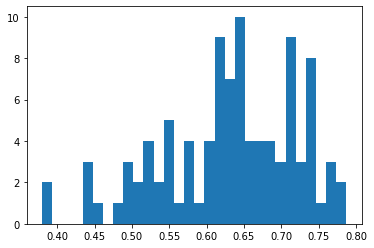

Val epoch 200, average corr 0.6305012486432163
Saving model...
Epoch: [201][10/101]	loss 3.960 (3.311)	image_p 0.690 (0.757)	gene_p 0.823 (0.755)
Epoch: [201][20/101]	loss 3.260 (3.143)	image_p 0.802 (0.766)	gene_p 0.724 (0.778)
Epoch: [201][30/101]	loss 2.328 (3.171)	image_p 0.808 (0.769)	gene_p 0.832 (0.770)
Epoch: [201][40/101]	loss 2.241 (3.113)	image_p 0.797 (0.772)	gene_p 0.908 (0.776)
Epoch: [201][50/101]	loss 3.472 (3.106)	image_p 0.663 (0.773)	gene_p 0.866 (0.778)
Epoch: [201][60/101]	loss 2.957 (3.066)	image_p 0.834 (0.778)	gene_p 0.814 (0.780)
Epoch: [201][70/101]	loss 0.948 (2.987)	image_p 0.959 (0.789)	gene_p 0.913 (0.784)
Epoch: [201][80/101]	loss 1.418 (2.918)	image_p 0.917 (0.796)	gene_p 0.900 (0.788)
Epoch: [201][90/101]	loss 3.136 (2.836)	image_p 0.760 (0.804)	gene_p 0.783 (0.792)
Epoch: [201][100/101]	loss 3.659 (2.762)	image_p 0.743 (0.811)	gene_p 0.789 (0.798)
Val epoch 201, average corr 0.6384465616013261
Epoch: [202][10/101]	loss 4.150 (3.237)	image_p 0.637 (0.77

Epoch: [210][40/101]	loss 2.896 (2.882)	image_p 0.842 (0.802)	gene_p 0.742 (0.782)
Epoch: [210][50/101]	loss 2.338 (2.822)	image_p 0.897 (0.806)	gene_p 0.862 (0.787)
Epoch: [210][60/101]	loss 2.624 (2.817)	image_p 0.769 (0.805)	gene_p 0.853 (0.788)
Epoch: [210][70/101]	loss 1.667 (2.790)	image_p 0.891 (0.808)	gene_p 0.905 (0.791)
Epoch: [210][80/101]	loss 2.330 (2.710)	image_p 0.879 (0.817)	gene_p 0.781 (0.795)
Epoch: [210][90/101]	loss 2.642 (2.675)	image_p 0.840 (0.821)	gene_p 0.776 (0.797)
Epoch: [210][100/101]	loss 2.088 (2.634)	image_p 0.826 (0.823)	gene_p 0.862 (0.798)
Val epoch 210, average corr 0.6309008139714769
Saving model...
Epoch: [211][10/101]	loss 2.972 (3.116)	image_p 0.792 (0.802)	gene_p 0.738 (0.758)
Epoch: [211][20/101]	loss 1.743 (2.982)	image_p 0.931 (0.809)	gene_p 0.851 (0.770)
Epoch: [211][30/101]	loss 3.549 (2.911)	image_p 0.780 (0.812)	gene_p 0.682 (0.774)
Epoch: [211][40/101]	loss 1.934 (2.847)	image_p 0.907 (0.818)	gene_p 0.828 (0.780)
Epoch: [211][50/101]	lo

Epoch: [219][80/101]	loss 3.205 (2.638)	image_p 0.704 (0.804)	gene_p 0.803 (0.804)
Epoch: [219][90/101]	loss 2.120 (2.624)	image_p 0.889 (0.807)	gene_p 0.788 (0.805)
Epoch: [219][100/101]	loss 2.581 (2.555)	image_p 0.774 (0.812)	gene_p 0.806 (0.810)
Val epoch 219, average corr 0.6463516877814327
Epoch: [220][10/101]	loss 2.142 (2.619)	image_p 0.947 (0.843)	gene_p 0.796 (0.771)
Epoch: [220][20/101]	loss 2.237 (2.895)	image_p 0.791 (0.794)	gene_p 0.833 (0.769)
Epoch: [220][30/101]	loss 2.306 (2.749)	image_p 0.838 (0.808)	gene_p 0.809 (0.779)
Epoch: [220][40/101]	loss 2.655 (2.771)	image_p 0.808 (0.806)	gene_p 0.878 (0.780)
Epoch: [220][50/101]	loss 3.722 (2.690)	image_p 0.773 (0.810)	gene_p 0.642 (0.787)
Epoch: [220][60/101]	loss 2.314 (2.719)	image_p 0.848 (0.811)	gene_p 0.833 (0.783)
Epoch: [220][70/101]	loss 2.000 (2.701)	image_p 0.854 (0.812)	gene_p 0.854 (0.785)
Epoch: [220][80/101]	loss 3.282 (2.632)	image_p 0.731 (0.819)	gene_p 0.741 (0.792)
Epoch: [220][90/101]	loss 1.892 (2.635)

Epoch: [229][10/101]	loss 1.942 (3.153)	image_p 0.917 (0.760)	gene_p 0.793 (0.760)
Epoch: [229][20/101]	loss 3.716 (3.081)	image_p 0.794 (0.760)	gene_p 0.643 (0.769)
Epoch: [229][30/101]	loss 1.985 (2.872)	image_p 0.813 (0.782)	gene_p 0.872 (0.792)
Epoch: [229][40/101]	loss 2.859 (2.887)	image_p 0.816 (0.788)	gene_p 0.835 (0.786)
Epoch: [229][50/101]	loss 1.139 (2.773)	image_p 0.954 (0.800)	gene_p 0.917 (0.792)
Epoch: [229][60/101]	loss 2.351 (2.778)	image_p 0.869 (0.800)	gene_p 0.764 (0.790)
Epoch: [229][70/101]	loss 2.644 (2.749)	image_p 0.835 (0.804)	gene_p 0.787 (0.786)
Epoch: [229][80/101]	loss 1.202 (2.748)	image_p 0.911 (0.803)	gene_p 0.925 (0.787)
Epoch: [229][90/101]	loss 2.119 (2.761)	image_p 0.880 (0.803)	gene_p 0.802 (0.783)
Epoch: [229][100/101]	loss 2.793 (2.802)	image_p 0.829 (0.802)	gene_p 0.770 (0.777)
Val epoch 229, average corr 0.6406910272342266
Epoch: [230][10/101]	loss 2.678 (2.751)	image_p 0.834 (0.789)	gene_p 0.770 (0.792)
Epoch: [230][20/101]	loss 2.873 (2.526)

Epoch: [238][50/101]	loss 2.313 (2.481)	image_p 0.849 (0.815)	gene_p 0.864 (0.813)
Epoch: [238][60/101]	loss 2.251 (2.495)	image_p 0.883 (0.816)	gene_p 0.811 (0.810)
Epoch: [238][70/101]	loss 3.028 (2.541)	image_p 0.763 (0.813)	gene_p 0.773 (0.808)
Epoch: [238][80/101]	loss 1.554 (2.465)	image_p 0.939 (0.819)	gene_p 0.868 (0.812)
Epoch: [238][90/101]	loss 3.435 (2.511)	image_p 0.778 (0.818)	gene_p 0.728 (0.808)
Epoch: [238][100/101]	loss 3.459 (2.467)	image_p 0.817 (0.819)	gene_p 0.738 (0.813)
Val epoch 238, average corr 0.6406438249334734
Epoch: [239][10/101]	loss 3.336 (2.646)	image_p 0.681 (0.833)	gene_p 0.762 (0.812)
Epoch: [239][20/101]	loss 0.620 (2.404)	image_p 0.954 (0.833)	gene_p 0.994 (0.834)
Epoch: [239][30/101]	loss 3.604 (2.424)	image_p 0.669 (0.819)	gene_p 0.785 (0.835)
Epoch: [239][40/101]	loss 1.605 (2.426)	image_p 0.924 (0.829)	gene_p 0.856 (0.820)
Epoch: [239][50/101]	loss 1.154 (2.345)	image_p 0.918 (0.836)	gene_p 0.913 (0.824)
Epoch: [239][60/101]	loss 3.028 (2.367)

Epoch: [247][90/101]	loss 1.606 (2.427)	image_p 0.849 (0.816)	gene_p 0.914 (0.823)
Epoch: [247][100/101]	loss 2.704 (2.454)	image_p 0.720 (0.813)	gene_p 0.795 (0.821)
Val epoch 247, average corr 0.6383408238249928
Epoch: [248][10/101]	loss 2.537 (2.364)	image_p 0.742 (0.833)	gene_p 0.901 (0.811)
Epoch: [248][20/101]	loss 2.473 (2.271)	image_p 0.859 (0.852)	gene_p 0.787 (0.815)
Epoch: [248][30/101]	loss 2.635 (2.348)	image_p 0.833 (0.841)	gene_p 0.762 (0.813)
Epoch: [248][40/101]	loss 2.960 (2.367)	image_p 0.821 (0.837)	gene_p 0.726 (0.811)
Epoch: [248][50/101]	loss 2.751 (2.436)	image_p 0.749 (0.829)	gene_p 0.813 (0.807)
Epoch: [248][60/101]	loss 3.005 (2.417)	image_p 0.738 (0.829)	gene_p 0.749 (0.808)
Epoch: [248][70/101]	loss 2.414 (2.398)	image_p 0.731 (0.830)	gene_p 0.889 (0.810)
Epoch: [248][80/101]	loss 2.603 (2.447)	image_p 0.805 (0.827)	gene_p 0.810 (0.808)
Epoch: [248][90/101]	loss 2.253 (2.493)	image_p 0.830 (0.822)	gene_p 0.827 (0.805)
Epoch: [248][100/101]	loss 2.410 (2.539

Epoch: [257][20/101]	loss 2.244 (2.342)	image_p 0.913 (0.834)	gene_p 0.778 (0.820)
Epoch: [257][30/101]	loss 3.884 (2.287)	image_p 0.685 (0.829)	gene_p 0.706 (0.825)
Epoch: [257][40/101]	loss 2.884 (2.223)	image_p 0.854 (0.837)	gene_p 0.728 (0.827)
Epoch: [257][50/101]	loss 2.406 (2.177)	image_p 0.862 (0.842)	gene_p 0.835 (0.831)
Epoch: [257][60/101]	loss 1.783 (2.186)	image_p 0.838 (0.844)	gene_p 0.876 (0.828)
Epoch: [257][70/101]	loss 1.568 (2.173)	image_p 0.900 (0.844)	gene_p 0.888 (0.830)
Epoch: [257][80/101]	loss 1.929 (2.189)	image_p 0.941 (0.845)	gene_p 0.830 (0.826)
Epoch: [257][90/101]	loss 3.347 (2.254)	image_p 0.787 (0.839)	gene_p 0.759 (0.823)
Epoch: [257][100/101]	loss 3.360 (2.265)	image_p 0.768 (0.838)	gene_p 0.785 (0.824)
Val epoch 257, average corr 0.6419823169786152
Epoch: [258][10/101]	loss 2.285 (1.946)	image_p 0.821 (0.841)	gene_p 0.787 (0.849)
Epoch: [258][20/101]	loss 1.490 (1.972)	image_p 0.871 (0.847)	gene_p 0.914 (0.855)
Epoch: [258][30/101]	loss 2.034 (2.125)

Epoch: [266][60/101]	loss 4.112 (2.372)	image_p 0.744 (0.822)	gene_p 0.669 (0.823)
Epoch: [266][70/101]	loss 4.342 (2.378)	image_p 0.708 (0.825)	gene_p 0.759 (0.823)
Epoch: [266][80/101]	loss 3.782 (2.424)	image_p 0.664 (0.824)	gene_p 0.772 (0.816)
Epoch: [266][90/101]	loss 1.598 (2.454)	image_p 0.788 (0.820)	gene_p 0.930 (0.813)
Epoch: [266][100/101]	loss 2.044 (2.476)	image_p 0.883 (0.817)	gene_p 0.888 (0.811)
Val epoch 266, average corr 0.6422736450517516
Epoch: [267][10/101]	loss 1.867 (1.858)	image_p 0.817 (0.857)	gene_p 0.887 (0.844)
Epoch: [267][20/101]	loss 3.137 (1.933)	image_p 0.701 (0.849)	gene_p 0.759 (0.851)
Epoch: [267][30/101]	loss 2.595 (1.961)	image_p 0.838 (0.852)	gene_p 0.754 (0.847)
Epoch: [267][40/101]	loss 1.566 (2.015)	image_p 0.918 (0.851)	gene_p 0.881 (0.838)
Epoch: [267][50/101]	loss 2.068 (2.058)	image_p 0.802 (0.846)	gene_p 0.891 (0.840)
Epoch: [267][60/101]	loss 1.857 (2.118)	image_p 0.850 (0.838)	gene_p 0.874 (0.837)
Epoch: [267][70/101]	loss 2.804 (2.145)

Epoch: [275][100/101]	loss 1.891 (1.968)	image_p 0.925 (0.842)	gene_p 0.794 (0.859)
Val epoch 275, average corr 0.6255677492346106
Epoch: [276][10/101]	loss 2.291 (2.337)	image_p 0.826 (0.819)	gene_p 0.808 (0.830)
Epoch: [276][20/101]	loss 0.827 (2.100)	image_p 0.945 (0.831)	gene_p 0.924 (0.847)
Epoch: [276][30/101]	loss 2.769 (2.103)	image_p 0.843 (0.830)	gene_p 0.766 (0.844)
Epoch: [276][40/101]	loss 1.296 (2.165)	image_p 0.925 (0.830)	gene_p 0.855 (0.835)
Epoch: [276][50/101]	loss 2.190 (2.094)	image_p 0.901 (0.839)	gene_p 0.774 (0.836)
Epoch: [276][60/101]	loss 1.244 (2.088)	image_p 0.924 (0.838)	gene_p 0.882 (0.837)
Epoch: [276][70/101]	loss 1.115 (2.033)	image_p 0.888 (0.843)	gene_p 0.933 (0.842)
Epoch: [276][80/101]	loss 1.032 (2.104)	image_p 0.954 (0.840)	gene_p 0.886 (0.842)
Epoch: [276][90/101]	loss 1.108 (2.106)	image_p 0.853 (0.839)	gene_p 0.950 (0.842)
Epoch: [276][100/101]	loss 3.054 (2.138)	image_p 0.747 (0.837)	gene_p 0.821 (0.839)
Val epoch 276, average corr 0.64221051

Epoch: [285][30/101]	loss 1.094 (1.930)	image_p 0.925 (0.854)	gene_p 0.906 (0.837)
Epoch: [285][40/101]	loss 1.985 (1.951)	image_p 0.923 (0.855)	gene_p 0.896 (0.843)
Epoch: [285][50/101]	loss 1.176 (1.946)	image_p 0.922 (0.855)	gene_p 0.897 (0.847)
Epoch: [285][60/101]	loss 1.690 (1.886)	image_p 0.812 (0.858)	gene_p 0.932 (0.852)
Epoch: [285][70/101]	loss 1.219 (1.874)	image_p 0.917 (0.858)	gene_p 0.889 (0.853)
Epoch: [285][80/101]	loss 2.212 (1.878)	image_p 0.789 (0.857)	gene_p 0.856 (0.855)
Epoch: [285][90/101]	loss 0.854 (1.843)	image_p 0.951 (0.859)	gene_p 0.889 (0.857)
Epoch: [285][100/101]	loss 1.998 (1.839)	image_p 0.912 (0.862)	gene_p 0.795 (0.855)
Val epoch 285, average corr 0.6480532637436083
Epoch: [286][10/101]	loss 2.683 (1.581)	image_p 0.788 (0.857)	gene_p 0.736 (0.891)
Epoch: [286][20/101]	loss 1.170 (1.655)	image_p 0.810 (0.866)	gene_p 0.977 (0.877)
Epoch: [286][30/101]	loss 2.384 (1.757)	image_p 0.829 (0.864)	gene_p 0.875 (0.873)
Epoch: [286][40/101]	loss 1.000 (1.700)

Epoch: [294][70/101]	loss 1.873 (1.716)	image_p 0.843 (0.867)	gene_p 0.879 (0.870)
Epoch: [294][80/101]	loss 2.484 (1.766)	image_p 0.696 (0.861)	gene_p 0.870 (0.870)
Epoch: [294][90/101]	loss 0.986 (1.732)	image_p 0.964 (0.863)	gene_p 0.876 (0.872)
Epoch: [294][100/101]	loss 0.969 (1.736)	image_p 0.956 (0.864)	gene_p 0.935 (0.871)
Val epoch 294, average corr 0.6508817310081865
Epoch: [295][10/101]	loss 1.520 (1.612)	image_p 0.946 (0.893)	gene_p 0.836 (0.884)
Epoch: [295][20/101]	loss 2.175 (1.758)	image_p 0.799 (0.872)	gene_p 0.852 (0.876)
Epoch: [295][30/101]	loss 1.303 (1.646)	image_p 0.900 (0.881)	gene_p 0.866 (0.880)
Epoch: [295][40/101]	loss 1.911 (1.709)	image_p 0.790 (0.869)	gene_p 0.965 (0.875)
Epoch: [295][50/101]	loss 2.598 (1.762)	image_p 0.720 (0.862)	gene_p 0.912 (0.873)
Epoch: [295][60/101]	loss 2.438 (1.804)	image_p 0.794 (0.861)	gene_p 0.889 (0.869)
Epoch: [295][70/101]	loss 2.119 (1.822)	image_p 0.851 (0.855)	gene_p 0.857 (0.871)
Epoch: [295][80/101]	loss 2.513 (1.805)

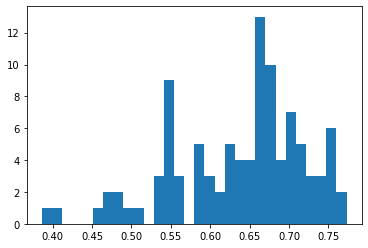

Val epoch 300, average corr 0.6376852328504863
Saving model...
Epoch: [301][10/101]	loss 1.354 (2.123)	image_p 0.931 (0.852)	gene_p 0.867 (0.855)
Epoch: [301][20/101]	loss 1.832 (1.971)	image_p 0.817 (0.860)	gene_p 0.842 (0.866)
Epoch: [301][30/101]	loss 1.455 (1.893)	image_p 0.870 (0.865)	gene_p 0.875 (0.859)
Epoch: [301][40/101]	loss 0.969 (1.895)	image_p 0.914 (0.867)	gene_p 0.950 (0.857)
Epoch: [301][50/101]	loss 1.855 (1.902)	image_p 0.841 (0.866)	gene_p 0.863 (0.855)
Epoch: [301][60/101]	loss 1.355 (1.947)	image_p 0.882 (0.860)	gene_p 0.918 (0.854)
Epoch: [301][70/101]	loss 1.339 (1.914)	image_p 0.946 (0.859)	gene_p 0.851 (0.861)
Epoch: [301][80/101]	loss 1.745 (1.854)	image_p 0.809 (0.863)	gene_p 0.940 (0.866)
Epoch: [301][90/101]	loss 1.092 (1.848)	image_p 0.918 (0.863)	gene_p 0.928 (0.869)
Epoch: [301][100/101]	loss 1.605 (1.855)	image_p 0.864 (0.861)	gene_p 0.874 (0.868)
Val epoch 301, average corr 0.6358729721069253
Epoch: [302][10/101]	loss 1.514 (1.714)	image_p 0.931 (0.86

Epoch: [310][40/101]	loss 2.160 (1.836)	image_p 0.706 (0.850)	gene_p 0.930 (0.872)
Epoch: [310][50/101]	loss 1.640 (1.854)	image_p 0.814 (0.849)	gene_p 0.954 (0.867)
Epoch: [310][60/101]	loss 1.659 (1.800)	image_p 0.911 (0.855)	gene_p 0.897 (0.869)
Epoch: [310][70/101]	loss 0.937 (1.831)	image_p 0.954 (0.856)	gene_p 0.935 (0.868)
Epoch: [310][80/101]	loss 2.057 (1.842)	image_p 0.942 (0.860)	gene_p 0.813 (0.869)
Epoch: [310][90/101]	loss 2.501 (1.852)	image_p 0.810 (0.856)	gene_p 0.876 (0.869)
Epoch: [310][100/101]	loss 0.620 (1.853)	image_p 0.937 (0.858)	gene_p 0.974 (0.867)
Val epoch 310, average corr 0.6381730056283597
Saving model...
Epoch: [311][10/101]	loss 1.904 (1.880)	image_p 0.923 (0.861)	gene_p 0.834 (0.852)
Epoch: [311][20/101]	loss 1.919 (1.841)	image_p 0.912 (0.849)	gene_p 0.829 (0.860)
Epoch: [311][30/101]	loss 1.970 (1.800)	image_p 0.941 (0.858)	gene_p 0.793 (0.865)
Epoch: [311][40/101]	loss 1.956 (1.807)	image_p 0.806 (0.856)	gene_p 0.837 (0.869)
Epoch: [311][50/101]	lo

Epoch: [319][80/101]	loss 1.877 (1.697)	image_p 0.897 (0.875)	gene_p 0.830 (0.872)
Epoch: [319][90/101]	loss 2.726 (1.729)	image_p 0.833 (0.870)	gene_p 0.798 (0.871)
Epoch: [319][100/101]	loss 0.886 (1.677)	image_p 0.911 (0.874)	gene_p 0.954 (0.875)
Val epoch 319, average corr 0.6374023522193631
Epoch: [320][10/101]	loss 1.543 (1.520)	image_p 0.859 (0.851)	gene_p 0.906 (0.894)
Epoch: [320][20/101]	loss 0.829 (1.707)	image_p 0.908 (0.854)	gene_p 0.983 (0.877)
Epoch: [320][30/101]	loss 1.263 (1.734)	image_p 0.949 (0.855)	gene_p 0.880 (0.870)
Epoch: [320][40/101]	loss 0.579 (1.714)	image_p 0.965 (0.862)	gene_p 0.963 (0.871)
Epoch: [320][50/101]	loss 1.509 (1.753)	image_p 0.882 (0.855)	gene_p 0.901 (0.875)
Epoch: [320][60/101]	loss 3.094 (1.751)	image_p 0.786 (0.856)	gene_p 0.799 (0.875)
Epoch: [320][70/101]	loss 1.103 (1.787)	image_p 0.884 (0.855)	gene_p 0.929 (0.873)
Epoch: [320][80/101]	loss 1.808 (1.758)	image_p 0.869 (0.859)	gene_p 0.865 (0.875)
Epoch: [320][90/101]	loss 1.938 (1.773)

Epoch: [329][10/101]	loss 1.554 (1.551)	image_p 0.955 (0.911)	gene_p 0.830 (0.868)
Epoch: [329][20/101]	loss 4.005 (2.035)	image_p 0.735 (0.855)	gene_p 0.730 (0.849)
Epoch: [329][30/101]	loss 1.373 (1.875)	image_p 0.884 (0.869)	gene_p 0.898 (0.857)
Epoch: [329][40/101]	loss 1.256 (1.826)	image_p 0.846 (0.870)	gene_p 0.925 (0.862)
Epoch: [329][50/101]	loss 2.025 (1.836)	image_p 0.851 (0.863)	gene_p 0.894 (0.869)
Epoch: [329][60/101]	loss 1.545 (1.843)	image_p 0.871 (0.861)	gene_p 0.884 (0.867)
Epoch: [329][70/101]	loss 3.160 (1.876)	image_p 0.788 (0.859)	gene_p 0.762 (0.865)
Epoch: [329][80/101]	loss 0.761 (1.813)	image_p 0.944 (0.862)	gene_p 0.985 (0.872)
Epoch: [329][90/101]	loss 0.742 (1.785)	image_p 0.939 (0.861)	gene_p 0.951 (0.875)
Epoch: [329][100/101]	loss 1.281 (1.786)	image_p 0.877 (0.860)	gene_p 0.925 (0.876)
Val epoch 329, average corr 0.6371156720718121
Epoch: [330][10/101]	loss 1.864 (1.465)	image_p 0.952 (0.885)	gene_p 0.763 (0.876)
Epoch: [330][20/101]	loss 2.981 (2.001)

Epoch: [338][50/101]	loss 3.382 (1.584)	image_p 0.780 (0.883)	gene_p 0.755 (0.881)
Epoch: [338][60/101]	loss 1.707 (1.616)	image_p 0.922 (0.880)	gene_p 0.846 (0.880)
Epoch: [338][70/101]	loss 0.691 (1.563)	image_p 0.991 (0.884)	gene_p 0.944 (0.884)
Epoch: [338][80/101]	loss 1.412 (1.593)	image_p 0.875 (0.882)	gene_p 0.867 (0.884)
Epoch: [338][90/101]	loss 0.910 (1.578)	image_p 0.901 (0.883)	gene_p 0.944 (0.884)
Epoch: [338][100/101]	loss 1.454 (1.578)	image_p 0.842 (0.880)	gene_p 0.945 (0.885)
Val epoch 338, average corr 0.6413241434590249
Epoch: [339][10/101]	loss 1.842 (1.756)	image_p 0.847 (0.856)	gene_p 0.877 (0.878)
Epoch: [339][20/101]	loss 2.012 (1.919)	image_p 0.860 (0.852)	gene_p 0.877 (0.863)
Epoch: [339][30/101]	loss 1.799 (1.890)	image_p 0.930 (0.858)	gene_p 0.747 (0.860)
Epoch: [339][40/101]	loss 1.273 (1.830)	image_p 0.933 (0.861)	gene_p 0.867 (0.864)
Epoch: [339][50/101]	loss 2.579 (1.775)	image_p 0.851 (0.864)	gene_p 0.805 (0.871)
Epoch: [339][60/101]	loss 1.102 (1.736)

Epoch: [347][90/101]	loss 3.452 (1.650)	image_p 0.679 (0.876)	gene_p 0.757 (0.876)
Epoch: [347][100/101]	loss 1.445 (1.611)	image_p 0.877 (0.880)	gene_p 0.882 (0.878)
Val epoch 347, average corr 0.6484693853287358
Epoch: [348][10/101]	loss 2.738 (2.144)	image_p 0.896 (0.850)	gene_p 0.825 (0.863)
Epoch: [348][20/101]	loss 1.651 (1.803)	image_p 0.897 (0.875)	gene_p 0.892 (0.874)
Epoch: [348][30/101]	loss 1.776 (1.820)	image_p 0.920 (0.868)	gene_p 0.841 (0.871)
Epoch: [348][40/101]	loss 1.856 (1.776)	image_p 0.952 (0.867)	gene_p 0.808 (0.880)
Epoch: [348][50/101]	loss 2.804 (1.730)	image_p 0.859 (0.871)	gene_p 0.681 (0.878)
Epoch: [348][60/101]	loss 1.095 (1.703)	image_p 0.899 (0.870)	gene_p 0.933 (0.879)
Epoch: [348][70/101]	loss 1.087 (1.689)	image_p 0.897 (0.869)	gene_p 0.923 (0.879)
Epoch: [348][80/101]	loss 1.175 (1.646)	image_p 0.940 (0.870)	gene_p 0.898 (0.883)
Epoch: [348][90/101]	loss 4.360 (1.646)	image_p 0.760 (0.871)	gene_p 0.684 (0.885)
Epoch: [348][100/101]	loss 1.106 (1.598

Epoch: [357][20/101]	loss 3.084 (1.382)	image_p 0.728 (0.883)	gene_p 0.861 (0.898)
Epoch: [357][30/101]	loss 2.044 (1.627)	image_p 0.850 (0.868)	gene_p 0.843 (0.884)
Epoch: [357][40/101]	loss 1.815 (1.647)	image_p 0.893 (0.869)	gene_p 0.854 (0.883)
Epoch: [357][50/101]	loss 0.472 (1.666)	image_p 0.997 (0.868)	gene_p 0.933 (0.883)
Epoch: [357][60/101]	loss 1.885 (1.701)	image_p 0.931 (0.868)	gene_p 0.778 (0.878)
Epoch: [357][70/101]	loss 1.060 (1.701)	image_p 0.920 (0.870)	gene_p 0.921 (0.874)
Epoch: [357][80/101]	loss 1.124 (1.724)	image_p 0.954 (0.866)	gene_p 0.871 (0.876)
Epoch: [357][90/101]	loss 2.002 (1.729)	image_p 0.814 (0.864)	gene_p 0.881 (0.876)
Epoch: [357][100/101]	loss 1.736 (1.703)	image_p 0.828 (0.868)	gene_p 0.919 (0.877)
Val epoch 357, average corr 0.6392447944547225
Epoch: [358][10/101]	loss 1.372 (1.644)	image_p 0.885 (0.888)	gene_p 0.898 (0.857)
Epoch: [358][20/101]	loss 1.088 (1.513)	image_p 0.897 (0.897)	gene_p 0.919 (0.875)
Epoch: [358][30/101]	loss 1.314 (1.471)

Epoch: [366][60/101]	loss 1.106 (1.796)	image_p 0.903 (0.866)	gene_p 0.910 (0.867)
Epoch: [366][70/101]	loss 2.106 (1.777)	image_p 0.922 (0.868)	gene_p 0.836 (0.869)
Epoch: [366][80/101]	loss 1.250 (1.761)	image_p 0.936 (0.869)	gene_p 0.894 (0.869)
Epoch: [366][90/101]	loss 2.827 (1.829)	image_p 0.857 (0.871)	gene_p 0.717 (0.859)
Epoch: [366][100/101]	loss 2.738 (1.825)	image_p 0.850 (0.870)	gene_p 0.842 (0.859)
Val epoch 366, average corr 0.6236711983364983
Epoch: [367][10/101]	loss 1.890 (1.925)	image_p 0.860 (0.874)	gene_p 0.831 (0.827)
Epoch: [367][20/101]	loss 1.536 (1.710)	image_p 0.848 (0.879)	gene_p 0.890 (0.858)
Epoch: [367][30/101]	loss 1.574 (1.625)	image_p 0.871 (0.880)	gene_p 0.877 (0.872)
Epoch: [367][40/101]	loss 0.743 (1.624)	image_p 0.919 (0.880)	gene_p 0.968 (0.874)
Epoch: [367][50/101]	loss 0.601 (1.583)	image_p 0.915 (0.880)	gene_p 0.995 (0.878)
Epoch: [367][60/101]	loss 1.718 (1.578)	image_p 0.946 (0.884)	gene_p 0.796 (0.876)
Epoch: [367][70/101]	loss 0.968 (1.529)

Epoch: [375][100/101]	loss 2.661 (1.477)	image_p 0.775 (0.888)	gene_p 0.891 (0.890)
Val epoch 375, average corr 0.6365079583789109
Epoch: [376][10/101]	loss 1.933 (1.462)	image_p 0.849 (0.866)	gene_p 0.833 (0.887)
Epoch: [376][20/101]	loss 1.610 (1.469)	image_p 0.882 (0.873)	gene_p 0.910 (0.890)
Epoch: [376][30/101]	loss 1.357 (1.526)	image_p 0.837 (0.866)	gene_p 0.936 (0.890)
Epoch: [376][40/101]	loss 0.713 (1.550)	image_p 0.940 (0.867)	gene_p 0.947 (0.886)
Epoch: [376][50/101]	loss 3.821 (1.539)	image_p 0.812 (0.870)	gene_p 0.704 (0.888)
Epoch: [376][60/101]	loss 0.515 (1.575)	image_p 0.999 (0.872)	gene_p 0.918 (0.883)
Epoch: [376][70/101]	loss 2.090 (1.570)	image_p 0.775 (0.872)	gene_p 0.945 (0.884)
Epoch: [376][80/101]	loss 0.435 (1.558)	image_p 0.966 (0.876)	gene_p 0.975 (0.881)
Epoch: [376][90/101]	loss 1.813 (1.582)	image_p 0.843 (0.870)	gene_p 0.846 (0.882)
Epoch: [376][100/101]	loss 3.346 (1.597)	image_p 0.702 (0.868)	gene_p 0.794 (0.881)
Val epoch 376, average corr 0.64351607

Epoch: [385][30/101]	loss 0.850 (1.517)	image_p 0.919 (0.892)	gene_p 0.966 (0.879)
Epoch: [385][40/101]	loss 1.916 (1.575)	image_p 0.828 (0.886)	gene_p 0.864 (0.875)
Epoch: [385][50/101]	loss 0.923 (1.603)	image_p 0.867 (0.882)	gene_p 0.964 (0.876)
Epoch: [385][60/101]	loss 2.119 (1.672)	image_p 0.855 (0.877)	gene_p 0.836 (0.873)
Epoch: [385][70/101]	loss 1.945 (1.686)	image_p 0.799 (0.877)	gene_p 0.881 (0.870)
Epoch: [385][80/101]	loss 1.504 (1.665)	image_p 0.902 (0.879)	gene_p 0.829 (0.873)
Epoch: [385][90/101]	loss 2.229 (1.680)	image_p 0.826 (0.877)	gene_p 0.830 (0.871)
Epoch: [385][100/101]	loss 0.746 (1.727)	image_p 0.967 (0.874)	gene_p 0.920 (0.870)
Val epoch 385, average corr 0.6417467482782319
Epoch: [386][10/101]	loss 1.308 (1.391)	image_p 0.907 (0.909)	gene_p 0.921 (0.898)
Epoch: [386][20/101]	loss 1.226 (1.377)	image_p 0.849 (0.893)	gene_p 0.937 (0.901)
Epoch: [386][30/101]	loss 2.406 (1.713)	image_p 0.861 (0.867)	gene_p 0.870 (0.891)
Epoch: [386][40/101]	loss 0.785 (1.609)

Epoch: [394][70/101]	loss 1.199 (1.707)	image_p 0.884 (0.877)	gene_p 0.919 (0.875)
Epoch: [394][80/101]	loss 2.764 (1.697)	image_p 0.869 (0.879)	gene_p 0.822 (0.877)
Epoch: [394][90/101]	loss 1.372 (1.773)	image_p 0.941 (0.876)	gene_p 0.827 (0.871)
Epoch: [394][100/101]	loss 1.164 (1.726)	image_p 0.890 (0.876)	gene_p 0.907 (0.873)
Val epoch 394, average corr 0.6513447065526334
Epoch: [395][10/101]	loss 2.829 (1.743)	image_p 0.911 (0.875)	gene_p 0.779 (0.863)
Epoch: [395][20/101]	loss 1.659 (1.784)	image_p 0.890 (0.863)	gene_p 0.822 (0.875)
Epoch: [395][30/101]	loss 1.054 (1.740)	image_p 0.950 (0.869)	gene_p 0.911 (0.882)
Epoch: [395][40/101]	loss 1.014 (1.646)	image_p 0.883 (0.870)	gene_p 0.925 (0.889)
Epoch: [395][50/101]	loss 2.250 (1.622)	image_p 0.841 (0.872)	gene_p 0.795 (0.886)
Epoch: [395][60/101]	loss 1.933 (1.608)	image_p 0.730 (0.871)	gene_p 0.952 (0.888)
Epoch: [395][70/101]	loss 1.416 (1.607)	image_p 0.854 (0.875)	gene_p 0.940 (0.887)
Epoch: [395][80/101]	loss 1.438 (1.593)

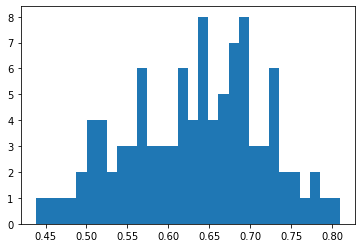

Val epoch 400, average corr 0.6322518720772958
Saving model...
Epoch: [401][10/101]	loss 0.964 (1.699)	image_p 0.930 (0.862)	gene_p 0.911 (0.875)
Epoch: [401][20/101]	loss 2.872 (1.551)	image_p 0.821 (0.876)	gene_p 0.855 (0.886)
Epoch: [401][30/101]	loss 0.682 (1.501)	image_p 0.891 (0.877)	gene_p 0.997 (0.892)
Epoch: [401][40/101]	loss 1.894 (1.477)	image_p 0.809 (0.881)	gene_p 0.896 (0.894)
Epoch: [401][50/101]	loss 0.682 (1.455)	image_p 0.968 (0.879)	gene_p 0.937 (0.895)
Epoch: [401][60/101]	loss 0.508 (1.454)	image_p 0.972 (0.881)	gene_p 0.952 (0.893)
Epoch: [401][70/101]	loss 1.815 (1.442)	image_p 0.867 (0.883)	gene_p 0.831 (0.892)
Epoch: [401][80/101]	loss 2.491 (1.460)	image_p 0.940 (0.884)	gene_p 0.802 (0.891)
Epoch: [401][90/101]	loss 2.130 (1.492)	image_p 0.764 (0.882)	gene_p 0.850 (0.888)
Epoch: [401][100/101]	loss 0.974 (1.474)	image_p 0.985 (0.883)	gene_p 0.855 (0.889)
Val epoch 401, average corr 0.646752559413322
Epoch: [402][10/101]	loss 1.379 (1.454)	image_p 0.966 (0.893

Epoch: [410][40/101]	loss 0.902 (1.442)	image_p 0.925 (0.894)	gene_p 0.924 (0.896)
Epoch: [410][50/101]	loss 1.680 (1.426)	image_p 0.773 (0.889)	gene_p 0.944 (0.901)
Epoch: [410][60/101]	loss 1.648 (1.463)	image_p 0.899 (0.884)	gene_p 0.876 (0.899)
Epoch: [410][70/101]	loss 0.618 (1.465)	image_p 0.972 (0.883)	gene_p 0.926 (0.899)
Epoch: [410][80/101]	loss 0.815 (1.504)	image_p 0.959 (0.882)	gene_p 0.932 (0.898)
Epoch: [410][90/101]	loss 0.690 (1.476)	image_p 0.943 (0.883)	gene_p 0.978 (0.901)
Epoch: [410][100/101]	loss 0.770 (1.495)	image_p 0.914 (0.884)	gene_p 0.974 (0.897)
Val epoch 410, average corr 0.643592970339549
Saving model...
Epoch: [411][10/101]	loss 2.658 (1.367)	image_p 0.781 (0.902)	gene_p 0.868 (0.900)
Epoch: [411][20/101]	loss 1.173 (1.500)	image_p 0.960 (0.896)	gene_p 0.835 (0.877)
Epoch: [411][30/101]	loss 2.656 (1.593)	image_p 0.887 (0.890)	gene_p 0.763 (0.868)
Epoch: [411][40/101]	loss 2.243 (1.536)	image_p 0.795 (0.893)	gene_p 0.898 (0.879)
Epoch: [411][50/101]	los

Epoch: [419][80/101]	loss 1.255 (1.435)	image_p 0.849 (0.893)	gene_p 0.915 (0.894)
Epoch: [419][90/101]	loss 0.788 (1.419)	image_p 0.948 (0.894)	gene_p 0.947 (0.897)
Epoch: [419][100/101]	loss 1.765 (1.414)	image_p 0.800 (0.893)	gene_p 0.938 (0.899)
Val epoch 419, average corr 0.6354243159618435
Epoch: [420][10/101]	loss 1.995 (1.564)	image_p 0.788 (0.901)	gene_p 0.911 (0.903)
Epoch: [420][20/101]	loss 1.634 (1.395)	image_p 0.873 (0.903)	gene_p 0.809 (0.894)
Epoch: [420][30/101]	loss 1.945 (1.576)	image_p 0.867 (0.878)	gene_p 0.851 (0.885)
Epoch: [420][40/101]	loss 0.950 (1.518)	image_p 0.936 (0.882)	gene_p 0.913 (0.890)
Epoch: [420][50/101]	loss 0.913 (1.479)	image_p 0.968 (0.885)	gene_p 0.922 (0.893)
Epoch: [420][60/101]	loss 1.678 (1.468)	image_p 0.918 (0.885)	gene_p 0.922 (0.894)
Epoch: [420][70/101]	loss 1.050 (1.461)	image_p 0.861 (0.885)	gene_p 0.974 (0.894)
Epoch: [420][80/101]	loss 1.246 (1.481)	image_p 0.893 (0.886)	gene_p 0.963 (0.892)
Epoch: [420][90/101]	loss 0.683 (1.461)

Epoch: [429][10/101]	loss 2.251 (2.036)	image_p 0.865 (0.867)	gene_p 0.914 (0.863)
Epoch: [429][20/101]	loss 0.656 (1.746)	image_p 0.974 (0.895)	gene_p 0.943 (0.866)
Epoch: [429][30/101]	loss 1.408 (1.591)	image_p 0.917 (0.895)	gene_p 0.902 (0.880)
Epoch: [429][40/101]	loss 0.567 (1.529)	image_p 0.951 (0.892)	gene_p 0.955 (0.883)
Epoch: [429][50/101]	loss 2.053 (1.589)	image_p 0.814 (0.895)	gene_p 0.825 (0.877)
Epoch: [429][60/101]	loss 0.696 (1.483)	image_p 0.981 (0.900)	gene_p 0.918 (0.887)
Epoch: [429][70/101]	loss 0.842 (1.479)	image_p 0.974 (0.904)	gene_p 0.881 (0.888)
Epoch: [429][80/101]	loss 0.936 (1.520)	image_p 0.901 (0.894)	gene_p 0.943 (0.887)
Epoch: [429][90/101]	loss 1.938 (1.498)	image_p 0.858 (0.892)	gene_p 0.859 (0.891)
Epoch: [429][100/101]	loss 3.935 (1.483)	image_p 0.702 (0.893)	gene_p 0.739 (0.891)
Val epoch 429, average corr 0.6332880230279649
Epoch: [430][10/101]	loss 2.591 (1.153)	image_p 0.777 (0.919)	gene_p 0.856 (0.919)
Epoch: [430][20/101]	loss 1.354 (1.167)

Epoch: [438][50/101]	loss 2.328 (1.688)	image_p 0.770 (0.866)	gene_p 0.847 (0.876)
Epoch: [438][60/101]	loss 1.473 (1.645)	image_p 0.869 (0.873)	gene_p 0.919 (0.879)
Epoch: [438][70/101]	loss 0.829 (1.629)	image_p 0.968 (0.876)	gene_p 0.914 (0.877)
Epoch: [438][80/101]	loss 0.932 (1.588)	image_p 0.918 (0.878)	gene_p 0.955 (0.882)
Epoch: [438][90/101]	loss 0.898 (1.562)	image_p 0.870 (0.881)	gene_p 0.968 (0.883)
Epoch: [438][100/101]	loss 2.871 (1.599)	image_p 0.871 (0.878)	gene_p 0.841 (0.883)
Val epoch 438, average corr 0.6185900932652552
Epoch: [439][10/101]	loss 1.538 (1.203)	image_p 0.854 (0.895)	gene_p 0.971 (0.912)
Epoch: [439][20/101]	loss 1.550 (1.459)	image_p 0.880 (0.872)	gene_p 0.851 (0.900)
Epoch: [439][30/101]	loss 3.574 (1.564)	image_p 0.684 (0.867)	gene_p 0.719 (0.889)
Epoch: [439][40/101]	loss 0.379 (1.462)	image_p 0.947 (0.878)	gene_p 0.999 (0.897)
Epoch: [439][50/101]	loss 1.489 (1.440)	image_p 0.912 (0.880)	gene_p 0.903 (0.900)
Epoch: [439][60/101]	loss 2.866 (1.501)

Epoch: [447][90/101]	loss 0.389 (1.454)	image_p 0.997 (0.894)	gene_p 0.951 (0.900)
Epoch: [447][100/101]	loss 1.076 (1.454)	image_p 0.930 (0.893)	gene_p 0.884 (0.898)
Val epoch 447, average corr 0.6254777339491576
Epoch: [448][10/101]	loss 1.243 (1.640)	image_p 0.903 (0.853)	gene_p 0.925 (0.885)
Epoch: [448][20/101]	loss 1.727 (1.462)	image_p 0.872 (0.885)	gene_p 0.922 (0.908)
Epoch: [448][30/101]	loss 1.055 (1.382)	image_p 0.948 (0.890)	gene_p 0.893 (0.908)
Epoch: [448][40/101]	loss 1.284 (1.475)	image_p 0.938 (0.887)	gene_p 0.869 (0.894)
Epoch: [448][50/101]	loss 3.883 (1.438)	image_p 0.863 (0.893)	gene_p 0.716 (0.893)
Epoch: [448][60/101]	loss 1.027 (1.381)	image_p 0.907 (0.900)	gene_p 0.928 (0.893)
Epoch: [448][70/101]	loss 2.040 (1.415)	image_p 0.871 (0.896)	gene_p 0.808 (0.891)
Epoch: [448][80/101]	loss 1.515 (1.409)	image_p 0.873 (0.896)	gene_p 0.921 (0.892)
Epoch: [448][90/101]	loss 2.017 (1.397)	image_p 0.812 (0.895)	gene_p 0.963 (0.895)
Epoch: [448][100/101]	loss 2.214 (1.457

Epoch: [457][20/101]	loss 1.614 (1.470)	image_p 0.892 (0.863)	gene_p 0.896 (0.898)
Epoch: [457][30/101]	loss 2.002 (1.558)	image_p 0.865 (0.864)	gene_p 0.844 (0.897)
Epoch: [457][40/101]	loss 2.271 (1.606)	image_p 0.839 (0.866)	gene_p 0.793 (0.896)
Epoch: [457][50/101]	loss 1.731 (1.681)	image_p 0.921 (0.867)	gene_p 0.790 (0.889)
Epoch: [457][60/101]	loss 1.902 (1.634)	image_p 0.812 (0.872)	gene_p 0.935 (0.890)
Epoch: [457][70/101]	loss 3.029 (1.623)	image_p 0.762 (0.871)	gene_p 0.801 (0.890)
Epoch: [457][80/101]	loss 1.842 (1.609)	image_p 0.885 (0.871)	gene_p 0.797 (0.889)
Epoch: [457][90/101]	loss 1.869 (1.632)	image_p 0.858 (0.874)	gene_p 0.888 (0.886)
Epoch: [457][100/101]	loss 1.737 (1.605)	image_p 0.947 (0.877)	gene_p 0.837 (0.886)
Val epoch 457, average corr 0.6295306203099241
Epoch: [458][10/101]	loss 1.329 (1.418)	image_p 0.862 (0.899)	gene_p 0.953 (0.880)
Epoch: [458][20/101]	loss 1.414 (1.724)	image_p 0.831 (0.868)	gene_p 0.921 (0.874)
Epoch: [458][30/101]	loss 1.740 (1.752)

Epoch: [466][60/101]	loss 0.948 (1.230)	image_p 0.895 (0.901)	gene_p 0.963 (0.913)
Epoch: [466][70/101]	loss 1.586 (1.250)	image_p 0.880 (0.899)	gene_p 0.875 (0.912)
Epoch: [466][80/101]	loss 1.051 (1.246)	image_p 0.899 (0.901)	gene_p 0.935 (0.915)
Epoch: [466][90/101]	loss 1.241 (1.277)	image_p 0.882 (0.898)	gene_p 0.950 (0.914)
Epoch: [466][100/101]	loss 1.884 (1.310)	image_p 0.780 (0.896)	gene_p 0.899 (0.912)
Val epoch 466, average corr 0.6207488056104675
Epoch: [467][10/101]	loss 1.028 (1.498)	image_p 0.899 (0.894)	gene_p 0.939 (0.902)
Epoch: [467][20/101]	loss 0.544 (1.351)	image_p 0.961 (0.899)	gene_p 0.973 (0.915)
Epoch: [467][30/101]	loss 3.387 (1.523)	image_p 0.795 (0.886)	gene_p 0.746 (0.896)
Epoch: [467][40/101]	loss 0.840 (1.626)	image_p 0.927 (0.886)	gene_p 0.949 (0.889)
Epoch: [467][50/101]	loss 1.932 (1.603)	image_p 0.852 (0.885)	gene_p 0.893 (0.890)
Epoch: [467][60/101]	loss 1.353 (1.636)	image_p 0.864 (0.881)	gene_p 0.949 (0.887)
Epoch: [467][70/101]	loss 1.353 (1.598)

Epoch: [475][100/101]	loss 1.033 (1.479)	image_p 0.863 (0.895)	gene_p 0.947 (0.894)
Val epoch 475, average corr 0.619424681519558
Epoch: [476][10/101]	loss 1.567 (1.504)	image_p 0.924 (0.908)	gene_p 0.926 (0.877)
Epoch: [476][20/101]	loss 0.824 (1.412)	image_p 0.966 (0.913)	gene_p 0.895 (0.889)
Epoch: [476][30/101]	loss 0.257 (1.506)	image_p 0.977 (0.902)	gene_p 0.998 (0.887)
Epoch: [476][40/101]	loss 0.668 (1.539)	image_p 0.928 (0.897)	gene_p 0.969 (0.888)
Epoch: [476][50/101]	loss 1.297 (1.586)	image_p 0.930 (0.895)	gene_p 0.888 (0.887)
Epoch: [476][60/101]	loss 2.646 (1.618)	image_p 0.729 (0.889)	gene_p 0.852 (0.885)
Epoch: [476][70/101]	loss 1.183 (1.630)	image_p 0.916 (0.885)	gene_p 0.873 (0.886)
Epoch: [476][80/101]	loss 1.115 (1.592)	image_p 0.991 (0.889)	gene_p 0.901 (0.887)
Epoch: [476][90/101]	loss 1.776 (1.588)	image_p 0.861 (0.888)	gene_p 0.815 (0.885)
Epoch: [476][100/101]	loss 0.537 (1.565)	image_p 0.965 (0.890)	gene_p 0.960 (0.885)
Val epoch 476, average corr 0.636692296

Epoch: [485][30/101]	loss 4.128 (1.428)	image_p 0.748 (0.882)	gene_p 0.870 (0.915)
Epoch: [485][40/101]	loss 1.120 (1.419)	image_p 0.916 (0.882)	gene_p 0.893 (0.912)
Epoch: [485][50/101]	loss 1.018 (1.347)	image_p 0.940 (0.886)	gene_p 0.938 (0.915)
Epoch: [485][60/101]	loss 1.677 (1.342)	image_p 0.880 (0.893)	gene_p 0.887 (0.910)
Epoch: [485][70/101]	loss 1.822 (1.324)	image_p 0.890 (0.896)	gene_p 0.814 (0.908)
Epoch: [485][80/101]	loss 0.896 (1.357)	image_p 0.921 (0.891)	gene_p 0.925 (0.909)
Epoch: [485][90/101]	loss 1.446 (1.365)	image_p 0.921 (0.891)	gene_p 0.841 (0.905)
Epoch: [485][100/101]	loss 1.233 (1.355)	image_p 0.919 (0.893)	gene_p 0.897 (0.906)
Val epoch 485, average corr 0.6372277420074507
Epoch: [486][10/101]	loss 2.140 (1.466)	image_p 0.859 (0.885)	gene_p 0.831 (0.901)
Epoch: [486][20/101]	loss 0.473 (1.421)	image_p 0.981 (0.879)	gene_p 0.968 (0.909)
Epoch: [486][30/101]	loss 1.190 (1.386)	image_p 0.947 (0.892)	gene_p 0.876 (0.909)
Epoch: [486][40/101]	loss 1.661 (1.415)

Epoch: [494][70/101]	loss 2.195 (1.373)	image_p 0.754 (0.891)	gene_p 0.914 (0.905)
Epoch: [494][80/101]	loss 1.845 (1.407)	image_p 0.854 (0.892)	gene_p 0.871 (0.904)
Epoch: [494][90/101]	loss 0.352 (1.401)	image_p 0.975 (0.893)	gene_p 0.975 (0.904)
Epoch: [494][100/101]	loss 0.566 (1.421)	image_p 0.952 (0.893)	gene_p 0.981 (0.902)
Val epoch 494, average corr 0.6233673058302708
Epoch: [495][10/101]	loss 2.198 (1.737)	image_p 0.889 (0.865)	gene_p 0.948 (0.884)
Epoch: [495][20/101]	loss 0.880 (1.535)	image_p 0.875 (0.871)	gene_p 0.973 (0.895)
Epoch: [495][30/101]	loss 1.329 (1.520)	image_p 0.925 (0.878)	gene_p 0.817 (0.888)
Epoch: [495][40/101]	loss 0.663 (1.424)	image_p 0.974 (0.887)	gene_p 0.924 (0.896)
Epoch: [495][50/101]	loss 0.680 (1.419)	image_p 0.947 (0.888)	gene_p 0.947 (0.894)
Epoch: [495][60/101]	loss 1.700 (1.416)	image_p 0.935 (0.892)	gene_p 0.898 (0.893)
Epoch: [495][70/101]	loss 0.911 (1.415)	image_p 0.940 (0.892)	gene_p 0.929 (0.893)
Epoch: [495][80/101]	loss 2.417 (1.388)

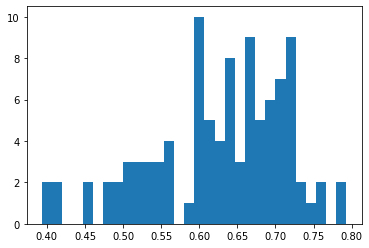

Val epoch 500, average corr 0.625608360376063
Saving model...
Epoch: [501][10/101]	loss 0.416 (1.299)	image_p 0.951 (0.894)	gene_p 0.993 (0.918)
Epoch: [501][20/101]	loss 1.091 (1.315)	image_p 0.929 (0.901)	gene_p 0.870 (0.912)
Epoch: [501][30/101]	loss 1.562 (1.306)	image_p 0.951 (0.902)	gene_p 0.800 (0.906)
Epoch: [501][40/101]	loss 1.778 (1.323)	image_p 0.847 (0.899)	gene_p 0.927 (0.908)
Epoch: [501][50/101]	loss 1.545 (1.297)	image_p 0.886 (0.901)	gene_p 0.898 (0.907)
Epoch: [501][60/101]	loss 0.535 (1.232)	image_p 0.936 (0.904)	gene_p 0.975 (0.911)
Epoch: [501][70/101]	loss 1.334 (1.230)	image_p 0.906 (0.903)	gene_p 0.867 (0.910)
Epoch: [501][80/101]	loss 0.774 (1.267)	image_p 0.911 (0.899)	gene_p 0.973 (0.908)
Epoch: [501][90/101]	loss 2.168 (1.275)	image_p 0.831 (0.901)	gene_p 0.952 (0.909)
Epoch: [501][100/101]	loss 0.582 (1.290)	image_p 0.993 (0.899)	gene_p 0.908 (0.907)
Val epoch 501, average corr 0.6192450605185484
Epoch: [502][10/101]	loss 2.169 (1.295)	image_p 0.857 (0.893

Epoch: [510][40/101]	loss 0.124 (1.463)	image_p 1.000 (0.894)	gene_p 0.999 (0.896)
Epoch: [510][50/101]	loss 1.143 (1.478)	image_p 0.893 (0.889)	gene_p 0.936 (0.897)
Epoch: [510][60/101]	loss 0.944 (1.422)	image_p 0.898 (0.893)	gene_p 0.941 (0.901)
Epoch: [510][70/101]	loss 2.759 (1.419)	image_p 0.747 (0.890)	gene_p 0.817 (0.903)
Epoch: [510][80/101]	loss 0.925 (1.402)	image_p 0.915 (0.892)	gene_p 0.910 (0.902)
Epoch: [510][90/101]	loss 0.688 (1.402)	image_p 0.974 (0.890)	gene_p 0.935 (0.904)
Epoch: [510][100/101]	loss 1.174 (1.404)	image_p 0.868 (0.889)	gene_p 0.975 (0.904)
Val epoch 510, average corr 0.6331993801675595
Saving model...
Epoch: [511][10/101]	loss 1.766 (1.383)	image_p 0.800 (0.885)	gene_p 0.887 (0.894)
Epoch: [511][20/101]	loss 0.567 (1.403)	image_p 0.944 (0.890)	gene_p 0.969 (0.899)
Epoch: [511][30/101]	loss 1.067 (1.305)	image_p 0.840 (0.895)	gene_p 1.000 (0.911)
Epoch: [511][40/101]	loss 2.894 (1.433)	image_p 0.739 (0.889)	gene_p 0.805 (0.905)
Epoch: [511][50/101]	lo

Epoch: [519][80/101]	loss 2.263 (1.226)	image_p 0.830 (0.906)	gene_p 0.861 (0.908)
Epoch: [519][90/101]	loss 0.209 (1.206)	image_p 0.998 (0.906)	gene_p 0.994 (0.910)
Epoch: [519][100/101]	loss 1.291 (1.204)	image_p 0.896 (0.906)	gene_p 0.935 (0.912)
Val epoch 519, average corr 0.6327558282143568
Epoch: [520][10/101]	loss 0.396 (1.485)	image_p 0.995 (0.892)	gene_p 0.961 (0.907)
Epoch: [520][20/101]	loss 1.234 (1.556)	image_p 0.903 (0.882)	gene_p 0.966 (0.894)
Epoch: [520][30/101]	loss 0.808 (1.463)	image_p 0.902 (0.893)	gene_p 0.975 (0.892)
Epoch: [520][40/101]	loss 2.386 (1.462)	image_p 0.829 (0.887)	gene_p 0.771 (0.894)
Epoch: [520][50/101]	loss 1.789 (1.403)	image_p 0.918 (0.894)	gene_p 0.834 (0.897)
Epoch: [520][60/101]	loss 2.480 (1.407)	image_p 0.860 (0.895)	gene_p 0.736 (0.896)
Epoch: [520][70/101]	loss 1.063 (1.421)	image_p 0.887 (0.891)	gene_p 0.926 (0.897)
Epoch: [520][80/101]	loss 1.397 (1.414)	image_p 0.871 (0.890)	gene_p 0.948 (0.899)
Epoch: [520][90/101]	loss 1.285 (1.388)

Epoch: [529][10/101]	loss 1.712 (1.158)	image_p 0.930 (0.907)	gene_p 0.842 (0.916)
Epoch: [529][20/101]	loss 0.966 (1.307)	image_p 0.920 (0.904)	gene_p 0.929 (0.908)
Epoch: [529][30/101]	loss 0.601 (1.328)	image_p 0.967 (0.908)	gene_p 0.945 (0.904)
Epoch: [529][40/101]	loss 0.974 (1.351)	image_p 0.894 (0.904)	gene_p 0.906 (0.903)
Epoch: [529][50/101]	loss 1.788 (1.359)	image_p 0.846 (0.903)	gene_p 0.890 (0.904)
Epoch: [529][60/101]	loss 1.148 (1.291)	image_p 0.907 (0.905)	gene_p 0.917 (0.907)
Epoch: [529][70/101]	loss 0.800 (1.312)	image_p 0.897 (0.901)	gene_p 0.971 (0.906)
Epoch: [529][80/101]	loss 1.653 (1.268)	image_p 0.871 (0.904)	gene_p 0.873 (0.912)
Epoch: [529][90/101]	loss 0.516 (1.261)	image_p 0.947 (0.905)	gene_p 0.973 (0.913)
Epoch: [529][100/101]	loss 2.670 (1.339)	image_p 0.829 (0.900)	gene_p 0.875 (0.911)
Val epoch 529, average corr 0.6158648373783703
Epoch: [530][10/101]	loss 1.045 (0.962)	image_p 0.885 (0.918)	gene_p 0.941 (0.953)
Epoch: [530][20/101]	loss 2.164 (1.200)

Epoch: [538][50/101]	loss 1.707 (1.559)	image_p 0.938 (0.883)	gene_p 0.892 (0.893)
Epoch: [538][60/101]	loss 0.968 (1.452)	image_p 0.965 (0.890)	gene_p 0.921 (0.899)
Epoch: [538][70/101]	loss 0.593 (1.393)	image_p 0.970 (0.896)	gene_p 0.949 (0.901)
Epoch: [538][80/101]	loss 0.431 (1.375)	image_p 0.984 (0.898)	gene_p 0.961 (0.904)
Epoch: [538][90/101]	loss 0.943 (1.357)	image_p 0.902 (0.898)	gene_p 0.925 (0.905)
Epoch: [538][100/101]	loss 1.713 (1.360)	image_p 0.828 (0.900)	gene_p 0.905 (0.904)
Val epoch 538, average corr 0.6293807733514051
Epoch: [539][10/101]	loss 2.776 (1.703)	image_p 0.902 (0.876)	gene_p 0.940 (0.912)
Epoch: [539][20/101]	loss 0.699 (1.652)	image_p 0.935 (0.869)	gene_p 0.944 (0.893)
Epoch: [539][30/101]	loss 0.808 (1.503)	image_p 0.972 (0.887)	gene_p 0.925 (0.903)
Epoch: [539][40/101]	loss 0.838 (1.516)	image_p 0.944 (0.885)	gene_p 0.902 (0.900)
Epoch: [539][50/101]	loss 0.599 (1.442)	image_p 0.948 (0.886)	gene_p 0.990 (0.905)
Epoch: [539][60/101]	loss 1.917 (1.449)

Epoch: [547][90/101]	loss 0.414 (1.345)	image_p 0.980 (0.901)	gene_p 0.983 (0.906)
Epoch: [547][100/101]	loss 1.668 (1.310)	image_p 0.858 (0.903)	gene_p 0.885 (0.908)
Val epoch 547, average corr 0.6363259398209182
Epoch: [548][10/101]	loss 1.234 (1.334)	image_p 0.889 (0.898)	gene_p 0.889 (0.904)
Epoch: [548][20/101]	loss 1.273 (1.316)	image_p 0.861 (0.894)	gene_p 0.900 (0.898)
Epoch: [548][30/101]	loss 1.206 (1.352)	image_p 0.841 (0.891)	gene_p 0.943 (0.908)
Epoch: [548][40/101]	loss 0.118 (1.329)	image_p 1.000 (0.894)	gene_p 0.999 (0.909)
Epoch: [548][50/101]	loss 2.574 (1.340)	image_p 0.896 (0.899)	gene_p 0.866 (0.909)
Epoch: [548][60/101]	loss 1.545 (1.309)	image_p 0.848 (0.901)	gene_p 0.840 (0.907)
Epoch: [548][70/101]	loss 1.531 (1.295)	image_p 0.855 (0.901)	gene_p 0.946 (0.911)
Epoch: [548][80/101]	loss 0.494 (1.293)	image_p 0.974 (0.903)	gene_p 0.964 (0.911)
Epoch: [548][90/101]	loss 0.847 (1.303)	image_p 0.942 (0.902)	gene_p 0.918 (0.911)
Epoch: [548][100/101]	loss 0.981 (1.292

Epoch: [557][20/101]	loss 0.664 (1.062)	image_p 0.973 (0.910)	gene_p 0.935 (0.933)
Epoch: [557][30/101]	loss 0.953 (1.147)	image_p 0.914 (0.907)	gene_p 0.958 (0.935)
Epoch: [557][40/101]	loss 1.208 (1.250)	image_p 0.906 (0.896)	gene_p 0.877 (0.923)
Epoch: [557][50/101]	loss 1.793 (1.260)	image_p 0.822 (0.894)	gene_p 0.883 (0.919)
Epoch: [557][60/101]	loss 0.979 (1.280)	image_p 0.999 (0.895)	gene_p 0.892 (0.917)
Epoch: [557][70/101]	loss 1.977 (1.287)	image_p 0.824 (0.900)	gene_p 0.873 (0.916)
Epoch: [557][80/101]	loss 0.350 (1.292)	image_p 0.960 (0.902)	gene_p 0.992 (0.914)
Epoch: [557][90/101]	loss 1.463 (1.292)	image_p 0.892 (0.902)	gene_p 0.908 (0.915)
Epoch: [557][100/101]	loss 0.772 (1.281)	image_p 0.881 (0.900)	gene_p 0.972 (0.916)
Val epoch 557, average corr 0.6224426680529167
Epoch: [558][10/101]	loss 2.160 (1.721)	image_p 0.863 (0.892)	gene_p 0.758 (0.861)
Epoch: [558][20/101]	loss 0.725 (1.489)	image_p 0.924 (0.907)	gene_p 0.948 (0.880)
Epoch: [558][30/101]	loss 0.774 (1.344)

Epoch: [566][60/101]	loss 1.542 (1.471)	image_p 0.944 (0.888)	gene_p 0.909 (0.899)
Epoch: [566][70/101]	loss 1.141 (1.427)	image_p 0.918 (0.891)	gene_p 0.914 (0.901)
Epoch: [566][80/101]	loss 1.537 (1.406)	image_p 0.975 (0.896)	gene_p 0.851 (0.902)
Epoch: [566][90/101]	loss 3.088 (1.421)	image_p 0.853 (0.894)	gene_p 0.787 (0.902)
Epoch: [566][100/101]	loss 0.935 (1.395)	image_p 0.879 (0.896)	gene_p 0.996 (0.906)
Val epoch 566, average corr 0.6150143598615763
Epoch: [567][10/101]	loss 0.608 (1.733)	image_p 0.973 (0.888)	gene_p 0.924 (0.885)
Epoch: [567][20/101]	loss 1.977 (1.424)	image_p 0.743 (0.892)	gene_p 0.922 (0.913)
Epoch: [567][30/101]	loss 0.521 (1.280)	image_p 0.979 (0.902)	gene_p 0.951 (0.921)
Epoch: [567][40/101]	loss 1.998 (1.364)	image_p 0.796 (0.894)	gene_p 0.861 (0.913)
Epoch: [567][50/101]	loss 1.103 (1.275)	image_p 0.911 (0.901)	gene_p 0.949 (0.915)
Epoch: [567][60/101]	loss 2.284 (1.300)	image_p 0.891 (0.902)	gene_p 0.825 (0.914)
Epoch: [567][70/101]	loss 2.091 (1.294)

Epoch: [575][100/101]	loss 1.226 (1.242)	image_p 0.964 (0.906)	gene_p 0.886 (0.911)
Val epoch 575, average corr 0.6348569610156133
Epoch: [576][10/101]	loss 1.385 (1.264)	image_p 0.874 (0.899)	gene_p 0.915 (0.890)
Epoch: [576][20/101]	loss 1.673 (1.340)	image_p 0.941 (0.899)	gene_p 0.882 (0.897)
Epoch: [576][30/101]	loss 1.297 (1.246)	image_p 0.943 (0.908)	gene_p 0.889 (0.904)
Epoch: [576][40/101]	loss 1.491 (1.404)	image_p 0.830 (0.891)	gene_p 0.954 (0.902)
Epoch: [576][50/101]	loss 1.216 (1.306)	image_p 0.876 (0.897)	gene_p 0.877 (0.908)
Epoch: [576][60/101]	loss 1.285 (1.320)	image_p 0.908 (0.897)	gene_p 0.913 (0.907)
Epoch: [576][70/101]	loss 1.847 (1.351)	image_p 0.870 (0.894)	gene_p 0.870 (0.906)
Epoch: [576][80/101]	loss 0.964 (1.323)	image_p 0.912 (0.896)	gene_p 0.925 (0.908)
Epoch: [576][90/101]	loss 1.819 (1.307)	image_p 0.847 (0.896)	gene_p 0.875 (0.909)
Epoch: [576][100/101]	loss 0.890 (1.337)	image_p 0.913 (0.897)	gene_p 0.970 (0.906)
Val epoch 576, average corr 0.63286082

Epoch: [585][30/101]	loss 0.132 (1.137)	image_p 0.998 (0.921)	gene_p 1.000 (0.923)
Epoch: [585][40/101]	loss 1.765 (1.124)	image_p 0.789 (0.914)	gene_p 0.905 (0.924)
Epoch: [585][50/101]	loss 1.358 (1.109)	image_p 0.880 (0.914)	gene_p 0.937 (0.926)
Epoch: [585][60/101]	loss 0.153 (1.119)	image_p 0.998 (0.916)	gene_p 0.999 (0.927)
Epoch: [585][70/101]	loss 1.203 (1.143)	image_p 0.939 (0.912)	gene_p 0.855 (0.926)
Epoch: [585][80/101]	loss 1.096 (1.145)	image_p 0.905 (0.913)	gene_p 0.933 (0.926)
Epoch: [585][90/101]	loss 1.451 (1.178)	image_p 0.904 (0.912)	gene_p 0.947 (0.923)
Epoch: [585][100/101]	loss 1.284 (1.176)	image_p 0.862 (0.914)	gene_p 0.876 (0.923)
Val epoch 585, average corr 0.6209768975383066
Epoch: [586][10/101]	loss 0.776 (1.419)	image_p 0.973 (0.889)	gene_p 0.936 (0.895)
Epoch: [586][20/101]	loss 2.373 (1.424)	image_p 0.864 (0.886)	gene_p 0.865 (0.904)
Epoch: [586][30/101]	loss 1.168 (1.621)	image_p 0.862 (0.879)	gene_p 0.931 (0.894)
Epoch: [586][40/101]	loss 1.493 (1.496)

Epoch: [594][70/101]	loss 1.128 (1.267)	image_p 0.918 (0.895)	gene_p 0.928 (0.916)
Epoch: [594][80/101]	loss 0.148 (1.269)	image_p 0.997 (0.895)	gene_p 1.000 (0.914)
Epoch: [594][90/101]	loss 0.690 (1.289)	image_p 0.902 (0.895)	gene_p 0.975 (0.912)
Epoch: [594][100/101]	loss 1.627 (1.303)	image_p 0.869 (0.893)	gene_p 0.954 (0.912)
Val epoch 594, average corr 0.6179689229076274
Epoch: [595][10/101]	loss 1.540 (1.516)	image_p 0.874 (0.884)	gene_p 0.850 (0.893)
Epoch: [595][20/101]	loss 1.307 (1.504)	image_p 0.782 (0.876)	gene_p 0.968 (0.894)
Epoch: [595][30/101]	loss 1.506 (1.411)	image_p 0.871 (0.887)	gene_p 0.837 (0.903)
Epoch: [595][40/101]	loss 1.816 (1.322)	image_p 0.843 (0.898)	gene_p 0.802 (0.909)
Epoch: [595][50/101]	loss 1.225 (1.291)	image_p 0.846 (0.902)	gene_p 0.924 (0.908)
Epoch: [595][60/101]	loss 1.519 (1.266)	image_p 0.920 (0.903)	gene_p 0.782 (0.909)
Epoch: [595][70/101]	loss 2.871 (1.287)	image_p 0.733 (0.901)	gene_p 0.868 (0.908)
Epoch: [595][80/101]	loss 1.457 (1.245)

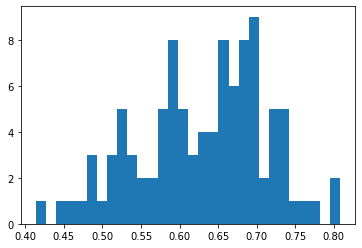

Val epoch 600, average corr 0.6291079910448173
Saving model...
Epoch: [601][10/101]	loss 0.751 (1.233)	image_p 0.949 (0.914)	gene_p 0.922 (0.895)
Epoch: [601][20/101]	loss 1.458 (1.164)	image_p 0.895 (0.902)	gene_p 0.852 (0.917)
Epoch: [601][30/101]	loss 1.054 (1.187)	image_p 0.926 (0.904)	gene_p 0.896 (0.918)
Epoch: [601][40/101]	loss 2.223 (1.192)	image_p 0.780 (0.900)	gene_p 0.862 (0.917)
Epoch: [601][50/101]	loss 2.431 (1.222)	image_p 0.876 (0.901)	gene_p 0.854 (0.916)
Epoch: [601][60/101]	loss 1.256 (1.227)	image_p 0.890 (0.903)	gene_p 0.949 (0.916)
Epoch: [601][70/101]	loss 1.525 (1.249)	image_p 0.782 (0.899)	gene_p 0.940 (0.912)
Epoch: [601][80/101]	loss 0.579 (1.241)	image_p 0.948 (0.903)	gene_p 0.961 (0.914)
Epoch: [601][90/101]	loss 0.776 (1.228)	image_p 0.951 (0.904)	gene_p 0.906 (0.914)
Epoch: [601][100/101]	loss 1.968 (1.225)	image_p 0.878 (0.905)	gene_p 0.797 (0.913)
Val epoch 601, average corr 0.622910353661842
Epoch: [602][10/101]	loss 1.164 (1.196)	image_p 0.925 (0.930

Epoch: [610][40/101]	loss 1.124 (1.201)	image_p 0.907 (0.909)	gene_p 0.917 (0.916)
Epoch: [610][50/101]	loss 0.241 (1.187)	image_p 0.972 (0.908)	gene_p 1.000 (0.917)
Epoch: [610][60/101]	loss 1.042 (1.205)	image_p 0.950 (0.907)	gene_p 0.868 (0.914)
Epoch: [610][70/101]	loss 1.097 (1.235)	image_p 0.973 (0.906)	gene_p 0.831 (0.909)
Epoch: [610][80/101]	loss 0.441 (1.207)	image_p 0.961 (0.907)	gene_p 0.975 (0.913)
Epoch: [610][90/101]	loss 1.203 (1.206)	image_p 0.947 (0.911)	gene_p 0.902 (0.912)
Epoch: [610][100/101]	loss 1.947 (1.220)	image_p 0.883 (0.911)	gene_p 0.842 (0.910)
Val epoch 610, average corr 0.6269400972758453
Saving model...
Epoch: [611][10/101]	loss 0.700 (0.993)	image_p 0.910 (0.931)	gene_p 0.968 (0.923)
Epoch: [611][20/101]	loss 1.448 (1.075)	image_p 0.879 (0.916)	gene_p 0.904 (0.926)
Epoch: [611][30/101]	loss 1.040 (0.999)	image_p 0.985 (0.921)	gene_p 0.861 (0.928)
Epoch: [611][40/101]	loss 1.030 (1.026)	image_p 0.926 (0.916)	gene_p 0.937 (0.929)
Epoch: [611][50/101]	lo

Epoch: [619][80/101]	loss 0.850 (1.301)	image_p 0.854 (0.903)	gene_p 0.998 (0.911)
Epoch: [619][90/101]	loss 1.227 (1.258)	image_p 0.980 (0.907)	gene_p 0.908 (0.913)
Epoch: [619][100/101]	loss 2.126 (1.255)	image_p 0.871 (0.909)	gene_p 0.800 (0.911)
Val epoch 619, average corr 0.6165616128781298
Epoch: [620][10/101]	loss 1.686 (1.260)	image_p 0.901 (0.902)	gene_p 0.824 (0.895)
Epoch: [620][20/101]	loss 0.560 (1.296)	image_p 0.999 (0.903)	gene_p 0.943 (0.899)
Epoch: [620][30/101]	loss 0.440 (1.340)	image_p 0.985 (0.907)	gene_p 0.961 (0.902)
Epoch: [620][40/101]	loss 0.300 (1.258)	image_p 0.994 (0.913)	gene_p 0.980 (0.907)
Epoch: [620][50/101]	loss 1.001 (1.375)	image_p 0.956 (0.907)	gene_p 0.883 (0.899)
Epoch: [620][60/101]	loss 1.136 (1.286)	image_p 0.904 (0.910)	gene_p 0.898 (0.907)
Epoch: [620][70/101]	loss 2.119 (1.249)	image_p 0.855 (0.911)	gene_p 0.925 (0.912)
Epoch: [620][80/101]	loss 0.619 (1.224)	image_p 0.949 (0.915)	gene_p 0.970 (0.912)
Epoch: [620][90/101]	loss 0.986 (1.213)

Epoch: [629][10/101]	loss 1.332 (1.047)	image_p 0.922 (0.917)	gene_p 0.865 (0.928)
Epoch: [629][20/101]	loss 0.948 (1.320)	image_p 0.941 (0.899)	gene_p 0.943 (0.907)
Epoch: [629][30/101]	loss 1.017 (1.360)	image_p 0.993 (0.905)	gene_p 0.947 (0.907)
Epoch: [629][40/101]	loss 1.409 (1.310)	image_p 0.904 (0.906)	gene_p 0.832 (0.909)
Epoch: [629][50/101]	loss 1.380 (1.305)	image_p 0.846 (0.905)	gene_p 0.998 (0.907)
Epoch: [629][60/101]	loss 1.090 (1.261)	image_p 0.904 (0.911)	gene_p 0.941 (0.909)
Epoch: [629][70/101]	loss 0.666 (1.237)	image_p 0.974 (0.913)	gene_p 0.909 (0.911)
Epoch: [629][80/101]	loss 0.582 (1.266)	image_p 0.940 (0.909)	gene_p 0.968 (0.907)
Epoch: [629][90/101]	loss 1.433 (1.258)	image_p 0.861 (0.908)	gene_p 0.903 (0.908)
Epoch: [629][100/101]	loss 0.494 (1.242)	image_p 0.935 (0.908)	gene_p 0.995 (0.910)
Val epoch 629, average corr 0.6166768546218769
Epoch: [630][10/101]	loss 2.070 (1.155)	image_p 0.940 (0.934)	gene_p 0.849 (0.923)
Epoch: [630][20/101]	loss 0.838 (1.150)

Epoch: [638][50/101]	loss 1.271 (1.235)	image_p 0.890 (0.895)	gene_p 0.875 (0.913)
Epoch: [638][60/101]	loss 0.956 (1.225)	image_p 0.886 (0.897)	gene_p 0.953 (0.916)
Epoch: [638][70/101]	loss 0.861 (1.207)	image_p 0.920 (0.900)	gene_p 0.933 (0.917)
Epoch: [638][80/101]	loss 1.804 (1.184)	image_p 0.822 (0.902)	gene_p 0.845 (0.916)
Epoch: [638][90/101]	loss 0.702 (1.171)	image_p 0.948 (0.902)	gene_p 0.935 (0.919)
Epoch: [638][100/101]	loss 0.595 (1.200)	image_p 0.947 (0.900)	gene_p 0.961 (0.917)
Val epoch 638, average corr 0.6163204248122994
Epoch: [639][10/101]	loss 0.992 (1.130)	image_p 0.897 (0.909)	gene_p 0.971 (0.914)
Epoch: [639][20/101]	loss 0.845 (1.150)	image_p 0.999 (0.905)	gene_p 0.901 (0.922)
Epoch: [639][30/101]	loss 1.063 (1.240)	image_p 0.925 (0.905)	gene_p 0.903 (0.914)
Epoch: [639][40/101]	loss 1.120 (1.249)	image_p 0.928 (0.902)	gene_p 0.923 (0.911)
Epoch: [639][50/101]	loss 0.775 (1.241)	image_p 0.923 (0.903)	gene_p 0.954 (0.913)
Epoch: [639][60/101]	loss 0.676 (1.225)

Epoch: [647][90/101]	loss 0.508 (1.199)	image_p 0.959 (0.911)	gene_p 0.975 (0.916)
Epoch: [647][100/101]	loss 1.054 (1.210)	image_p 0.916 (0.912)	gene_p 0.914 (0.914)
Val epoch 647, average corr 0.6123843473810604
Epoch: [648][10/101]	loss 1.459 (1.155)	image_p 0.944 (0.914)	gene_p 0.948 (0.916)
Epoch: [648][20/101]	loss 2.459 (1.198)	image_p 0.768 (0.909)	gene_p 0.832 (0.909)
Epoch: [648][30/101]	loss 1.166 (1.318)	image_p 0.913 (0.897)	gene_p 0.896 (0.910)
Epoch: [648][40/101]	loss 2.148 (1.301)	image_p 0.853 (0.897)	gene_p 0.936 (0.916)
Epoch: [648][50/101]	loss 0.448 (1.333)	image_p 0.961 (0.896)	gene_p 0.987 (0.912)
Epoch: [648][60/101]	loss 0.628 (1.332)	image_p 0.950 (0.891)	gene_p 0.947 (0.912)
Epoch: [648][70/101]	loss 0.547 (1.291)	image_p 0.941 (0.896)	gene_p 0.972 (0.913)
Epoch: [648][80/101]	loss 0.610 (1.299)	image_p 0.978 (0.894)	gene_p 0.954 (0.912)
Epoch: [648][90/101]	loss 0.586 (1.291)	image_p 0.937 (0.895)	gene_p 0.970 (0.913)
Epoch: [648][100/101]	loss 1.660 (1.281

Epoch: [657][20/101]	loss 1.810 (1.133)	image_p 0.872 (0.919)	gene_p 0.873 (0.914)
Epoch: [657][30/101]	loss 1.316 (1.191)	image_p 0.864 (0.908)	gene_p 0.913 (0.919)
Epoch: [657][40/101]	loss 0.580 (1.242)	image_p 0.918 (0.906)	gene_p 0.999 (0.920)
Epoch: [657][50/101]	loss 1.282 (1.274)	image_p 0.914 (0.906)	gene_p 0.901 (0.918)
Epoch: [657][60/101]	loss 0.158 (1.259)	image_p 0.997 (0.905)	gene_p 0.999 (0.918)
Epoch: [657][70/101]	loss 0.818 (1.195)	image_p 0.901 (0.909)	gene_p 0.973 (0.922)
Epoch: [657][80/101]	loss 0.695 (1.170)	image_p 0.910 (0.910)	gene_p 0.983 (0.926)
Epoch: [657][90/101]	loss 0.313 (1.142)	image_p 0.955 (0.911)	gene_p 0.999 (0.928)
Epoch: [657][100/101]	loss 0.678 (1.124)	image_p 0.956 (0.915)	gene_p 0.958 (0.928)
Val epoch 657, average corr 0.6070796915817683
Epoch: [658][10/101]	loss 0.836 (0.817)	image_p 0.900 (0.923)	gene_p 0.950 (0.955)
Epoch: [658][20/101]	loss 1.682 (1.070)	image_p 0.894 (0.925)	gene_p 0.861 (0.938)
Epoch: [658][30/101]	loss 1.385 (1.064)

Exception: Nan detected

In [18]:
hist = dict()
hist['loss'] = []
hist['corr_val'] = []
hist['image_loss'] = []
hist['image_prob'] = []
hist['gene_loss'] = []
hist['gene_prob'] = []

save_freq = 10

# Fix imagenet except for the last layer first
# for param in model.imagenet.parameters():
#     param.requires_grad = False
# for param in model.imagenet.fc.parameters():
#     param.requires_grad = True

for epoch in range(1000):
    loss, image_loss, image_prob, gene_loss, gene_prob = \
        train(epoch, train_loader, model, contrast, criterion_image, criterion_gene, optimizer, 
              gradient_clip=gradient_clip, print_freq=10, device=device)
    hist['loss'].append(loss)
    hist['image_loss'].append(image_loss)
    hist['image_prob'].append(image_prob)
    hist['gene_loss'].append(gene_loss)
    hist['gene_prob'].append(gene_prob)
    
    corr = test(epoch, test_loader, model, contrast, criterion_image, criterion_gene, optimizer, 
              gradient_clip=gradient_clip, print_freq=10, device=device)
    hist['corr_val'].append(corr)
    
    # Save model
    if epoch % save_freq == 0 and epoch != 0:
        print("Saving model...")
        state = { 'model': model.state_dict(),
                  'contrast': contrast.state_dict(),
                  'optimizer': optimizer.state_dict(),
                  'epoch': epoch}
        torch.save(state, os.path.join(model_dir, "epoch_{}.pt".format(epoch)))

torch.save(hist, os.path.join(model_dir, "hist.pt"))

In [21]:
torch.save(hist, os.path.join(model_dir, "hist.pt"))

### Train from epoch 600

In [24]:
hist = torch.load("./models/2_IGC_breast_cancer_FFPE/hist.pt")
n_epoch = 650
for key in hist.keys():
    hist[key] = [hist[key][_] for _ in range(n_epoch+1)]

model_file = "./models/2_IGC_breast_cancer_FFPE/epoch_{}.pt".format(n_epoch)
if model_file is not None:
    print("=> loading checkpoint '{}'".format(model_file))
    checkpoint = torch.load(model_file, map_location=device)
    start_epoch = checkpoint['epoch'] + 1
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    contrast.load_state_dict(checkpoint['contrast'])
    del checkpoint

=> loading checkpoint './models/2_IGC_breast_cancer_FFPE/epoch_650.pt'


Epoch: [651][10/101]	loss 0.800 (1.083)	image_p 0.953 (0.899)	gene_p 0.941 (0.947)
Epoch: [651][20/101]	loss 1.161 (1.275)	image_p 0.869 (0.905)	gene_p 0.916 (0.929)
Epoch: [651][30/101]	loss 0.339 (1.126)	image_p 0.990 (0.918)	gene_p 0.980 (0.934)
Epoch: [651][40/101]	loss 1.279 (1.137)	image_p 0.897 (0.919)	gene_p 0.925 (0.930)
Epoch: [651][50/101]	loss 0.807 (1.139)	image_p 0.920 (0.914)	gene_p 0.927 (0.927)
Epoch: [651][60/101]	loss 1.010 (1.134)	image_p 0.886 (0.912)	gene_p 0.925 (0.924)
Epoch: [651][70/101]	loss 0.746 (1.129)	image_p 0.924 (0.913)	gene_p 0.950 (0.923)
Epoch: [651][80/101]	loss 1.047 (1.155)	image_p 0.874 (0.912)	gene_p 0.928 (0.921)
Epoch: [651][90/101]	loss 0.254 (1.147)	image_p 0.997 (0.912)	gene_p 0.990 (0.920)
Epoch: [651][100/101]	loss 1.299 (1.173)	image_p 0.897 (0.909)	gene_p 0.855 (0.920)
Val epoch 651, average corr 0.6150557794206005
Epoch: [652][10/101]	loss 2.034 (1.419)	image_p 0.820 (0.873)	gene_p 0.825 (0.895)
Epoch: [652][20/101]	loss 0.602 (1.530)

Epoch: [660][50/101]	loss 0.931 (1.101)	image_p 0.876 (0.916)	gene_p 0.942 (0.920)
Epoch: [660][60/101]	loss 1.163 (1.100)	image_p 0.901 (0.916)	gene_p 0.909 (0.920)
Epoch: [660][70/101]	loss 1.664 (1.120)	image_p 0.848 (0.912)	gene_p 0.939 (0.920)
Epoch: [660][80/101]	loss 0.849 (1.160)	image_p 0.886 (0.909)	gene_p 0.975 (0.916)
Epoch: [660][90/101]	loss 1.391 (1.193)	image_p 0.865 (0.905)	gene_p 0.921 (0.915)
Epoch: [660][100/101]	loss 1.209 (1.211)	image_p 0.893 (0.905)	gene_p 0.918 (0.914)
Val epoch 660, average corr 0.6168819096888306
Saving model...
Epoch: [661][10/101]	loss 0.734 (1.211)	image_p 0.946 (0.904)	gene_p 0.952 (0.921)
Epoch: [661][20/101]	loss 1.525 (1.251)	image_p 0.858 (0.902)	gene_p 0.865 (0.915)
Epoch: [661][30/101]	loss 1.500 (1.197)	image_p 0.868 (0.903)	gene_p 0.872 (0.918)
Epoch: [661][40/101]	loss 0.768 (1.156)	image_p 0.887 (0.905)	gene_p 0.984 (0.926)
Epoch: [661][50/101]	loss 0.229 (1.082)	image_p 0.985 (0.911)	gene_p 1.000 (0.931)
Epoch: [661][60/101]	lo

Epoch: [669][90/101]	loss 1.118 (1.226)	image_p 0.868 (0.909)	gene_p 0.961 (0.911)
Epoch: [669][100/101]	loss 2.486 (1.225)	image_p 0.900 (0.909)	gene_p 0.830 (0.912)
Val epoch 669, average corr 0.6176456942583889
Epoch: [670][10/101]	loss 0.425 (1.298)	image_p 0.969 (0.903)	gene_p 0.975 (0.909)
Epoch: [670][20/101]	loss 1.085 (1.261)	image_p 0.943 (0.900)	gene_p 0.873 (0.911)
Epoch: [670][30/101]	loss 0.749 (1.169)	image_p 0.971 (0.907)	gene_p 0.894 (0.911)
Epoch: [670][40/101]	loss 0.647 (1.188)	image_p 0.972 (0.905)	gene_p 0.951 (0.913)
Epoch: [670][50/101]	loss 2.699 (1.173)	image_p 0.809 (0.904)	gene_p 0.750 (0.914)
Epoch: [670][60/101]	loss 0.604 (1.228)	image_p 0.962 (0.903)	gene_p 0.907 (0.911)
Epoch: [670][70/101]	loss 0.995 (1.195)	image_p 0.964 (0.903)	gene_p 0.936 (0.916)
Epoch: [670][80/101]	loss 1.020 (1.196)	image_p 0.858 (0.900)	gene_p 0.934 (0.919)
Epoch: [670][90/101]	loss 1.257 (1.183)	image_p 0.914 (0.902)	gene_p 0.890 (0.920)
Epoch: [670][100/101]	loss 1.248 (1.181

Epoch: [679][20/101]	loss 1.435 (1.106)	image_p 0.859 (0.912)	gene_p 1.000 (0.923)
Epoch: [679][30/101]	loss 0.880 (1.138)	image_p 0.919 (0.903)	gene_p 0.975 (0.934)
Epoch: [679][40/101]	loss 0.585 (1.181)	image_p 0.931 (0.903)	gene_p 0.972 (0.929)
Epoch: [679][50/101]	loss 1.636 (1.164)	image_p 0.842 (0.907)	gene_p 0.888 (0.929)
Epoch: [679][60/101]	loss 1.022 (1.136)	image_p 0.875 (0.907)	gene_p 0.924 (0.931)
Epoch: [679][70/101]	loss 1.308 (1.164)	image_p 0.824 (0.903)	gene_p 0.947 (0.932)
Epoch: [679][80/101]	loss 1.247 (1.161)	image_p 0.881 (0.904)	gene_p 0.915 (0.930)
Epoch: [679][90/101]	loss 2.305 (1.172)	image_p 0.899 (0.906)	gene_p 0.889 (0.928)
Epoch: [679][100/101]	loss 0.938 (1.166)	image_p 0.907 (0.907)	gene_p 0.925 (0.928)
Val epoch 679, average corr 0.613549505419159
Epoch: [680][10/101]	loss 1.145 (0.917)	image_p 0.936 (0.909)	gene_p 0.890 (0.951)
Epoch: [680][20/101]	loss 0.648 (1.076)	image_p 0.904 (0.911)	gene_p 0.999 (0.923)
Epoch: [680][30/101]	loss 1.200 (1.017)	

Epoch: [688][60/101]	loss 0.844 (1.215)	image_p 0.900 (0.912)	gene_p 0.952 (0.905)
Epoch: [688][70/101]	loss 1.632 (1.190)	image_p 0.850 (0.911)	gene_p 0.875 (0.909)
Epoch: [688][80/101]	loss 1.567 (1.197)	image_p 0.802 (0.908)	gene_p 0.905 (0.909)
Epoch: [688][90/101]	loss 0.827 (1.167)	image_p 0.925 (0.910)	gene_p 0.950 (0.912)
Epoch: [688][100/101]	loss 2.006 (1.160)	image_p 0.824 (0.911)	gene_p 0.940 (0.914)
Val epoch 688, average corr 0.611102369282654
Epoch: [689][10/101]	loss 0.674 (0.803)	image_p 0.941 (0.938)	gene_p 0.950 (0.936)
Epoch: [689][20/101]	loss 2.208 (0.962)	image_p 0.861 (0.932)	gene_p 0.866 (0.926)
Epoch: [689][30/101]	loss 0.837 (0.911)	image_p 0.900 (0.932)	gene_p 0.948 (0.930)
Epoch: [689][40/101]	loss 0.272 (0.944)	image_p 0.994 (0.927)	gene_p 0.982 (0.931)
Epoch: [689][50/101]	loss 1.556 (1.000)	image_p 0.890 (0.923)	gene_p 0.884 (0.932)
Epoch: [689][60/101]	loss 0.803 (1.017)	image_p 0.969 (0.923)	gene_p 0.905 (0.931)
Epoch: [689][70/101]	loss 1.121 (1.009)	

Epoch: [697][100/101]	loss 1.031 (1.121)	image_p 0.875 (0.913)	gene_p 0.945 (0.921)
Val epoch 697, average corr 0.6097622290772106
Epoch: [698][10/101]	loss 1.015 (1.191)	image_p 0.896 (0.893)	gene_p 0.902 (0.913)
Epoch: [698][20/101]	loss 0.426 (1.023)	image_p 0.968 (0.908)	gene_p 0.975 (0.925)
Epoch: [698][30/101]	loss 1.008 (1.016)	image_p 0.873 (0.904)	gene_p 0.954 (0.932)
Epoch: [698][40/101]	loss 1.253 (1.072)	image_p 0.871 (0.908)	gene_p 0.916 (0.927)
Epoch: [698][50/101]	loss 0.695 (1.031)	image_p 0.921 (0.914)	gene_p 0.973 (0.929)
Epoch: [698][60/101]	loss 2.151 (1.069)	image_p 0.904 (0.911)	gene_p 0.903 (0.928)
Epoch: [698][70/101]	loss 0.675 (1.034)	image_p 0.958 (0.915)	gene_p 0.930 (0.931)
Epoch: [698][80/101]	loss 0.648 (1.017)	image_p 0.928 (0.917)	gene_p 0.996 (0.931)
Epoch: [698][90/101]	loss 1.306 (1.029)	image_p 0.923 (0.915)	gene_p 0.832 (0.930)
Epoch: [698][100/101]	loss 1.375 (1.029)	image_p 0.936 (0.915)	gene_p 0.808 (0.928)
Val epoch 698, average corr 0.60846299

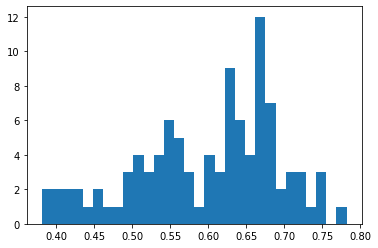

Val epoch 700, average corr 0.5980349163857029
Saving model...
Epoch: [701][10/101]	loss 0.516 (0.700)	image_p 0.968 (0.945)	gene_p 0.967 (0.962)
Epoch: [701][20/101]	loss 1.848 (0.958)	image_p 0.859 (0.920)	gene_p 0.862 (0.937)
Epoch: [701][30/101]	loss 1.130 (1.139)	image_p 0.894 (0.907)	gene_p 0.932 (0.930)
Epoch: [701][40/101]	loss 0.822 (1.079)	image_p 0.923 (0.910)	gene_p 0.938 (0.932)
Epoch: [701][50/101]	loss 1.049 (1.161)	image_p 0.924 (0.907)	gene_p 0.874 (0.927)
Epoch: [701][60/101]	loss 0.410 (1.170)	image_p 0.973 (0.905)	gene_p 0.973 (0.928)
Epoch: [701][70/101]	loss 1.757 (1.175)	image_p 0.813 (0.904)	gene_p 0.858 (0.925)
Epoch: [701][80/101]	loss 1.203 (1.172)	image_p 0.833 (0.905)	gene_p 0.941 (0.925)
Epoch: [701][90/101]	loss 1.662 (1.159)	image_p 0.881 (0.903)	gene_p 0.810 (0.926)
Epoch: [701][100/101]	loss 0.843 (1.133)	image_p 0.960 (0.906)	gene_p 0.910 (0.928)
Val epoch 701, average corr 0.5931451835896456
Epoch: [702][10/101]	loss 0.109 (0.979)	image_p 1.000 (0.91

Epoch: [710][40/101]	loss 0.834 (0.999)	image_p 0.890 (0.914)	gene_p 0.964 (0.940)
Epoch: [710][50/101]	loss 1.263 (0.996)	image_p 0.834 (0.913)	gene_p 0.974 (0.940)
Epoch: [710][60/101]	loss 1.217 (1.021)	image_p 0.899 (0.916)	gene_p 0.902 (0.938)
Epoch: [710][70/101]	loss 1.866 (1.090)	image_p 0.836 (0.915)	gene_p 0.839 (0.930)
Epoch: [710][80/101]	loss 1.196 (1.077)	image_p 0.916 (0.913)	gene_p 0.881 (0.932)
Epoch: [710][90/101]	loss 0.503 (1.079)	image_p 0.963 (0.913)	gene_p 0.973 (0.932)
Epoch: [710][100/101]	loss 1.388 (1.094)	image_p 0.896 (0.913)	gene_p 0.875 (0.929)
Val epoch 710, average corr 0.6115676061499932
Saving model...
Epoch: [711][10/101]	loss 1.305 (0.830)	image_p 0.923 (0.937)	gene_p 0.881 (0.936)
Epoch: [711][20/101]	loss 0.895 (0.799)	image_p 0.924 (0.940)	gene_p 0.923 (0.949)
Epoch: [711][30/101]	loss 2.596 (0.915)	image_p 0.895 (0.945)	gene_p 0.793 (0.938)
Epoch: [711][40/101]	loss 0.859 (0.915)	image_p 0.948 (0.940)	gene_p 0.944 (0.940)
Epoch: [711][50/101]	lo

Epoch: [719][80/101]	loss 1.452 (1.105)	image_p 0.776 (0.913)	gene_p 0.973 (0.925)
Epoch: [719][90/101]	loss 1.079 (1.092)	image_p 0.928 (0.913)	gene_p 0.859 (0.925)
Epoch: [719][100/101]	loss 0.293 (1.104)	image_p 0.967 (0.912)	gene_p 0.996 (0.924)
Val epoch 719, average corr 0.6160786795973293
Epoch: [720][10/101]	loss 1.436 (1.081)	image_p 0.940 (0.934)	gene_p 0.841 (0.921)
Epoch: [720][20/101]	loss 0.702 (0.997)	image_p 0.921 (0.926)	gene_p 0.969 (0.930)
Epoch: [720][30/101]	loss 1.415 (0.933)	image_p 0.882 (0.928)	gene_p 0.875 (0.935)
Epoch: [720][40/101]	loss 0.875 (0.894)	image_p 0.951 (0.931)	gene_p 0.909 (0.936)
Epoch: [720][50/101]	loss 0.571 (0.882)	image_p 0.971 (0.928)	gene_p 0.929 (0.939)
Epoch: [720][60/101]	loss 1.104 (0.907)	image_p 0.896 (0.923)	gene_p 0.901 (0.938)
Epoch: [720][70/101]	loss 0.106 (0.907)	image_p 1.000 (0.922)	gene_p 1.000 (0.937)
Epoch: [720][80/101]	loss 0.320 (0.890)	image_p 0.997 (0.925)	gene_p 0.954 (0.939)
Epoch: [720][90/101]	loss 0.761 (0.922)

Epoch: [729][10/101]	loss 1.579 (1.032)	image_p 0.841 (0.900)	gene_p 0.912 (0.940)
Epoch: [729][20/101]	loss 0.632 (1.115)	image_p 0.947 (0.910)	gene_p 0.966 (0.932)
Epoch: [729][30/101]	loss 1.116 (1.141)	image_p 0.921 (0.908)	gene_p 0.935 (0.927)
Epoch: [729][40/101]	loss 1.307 (1.179)	image_p 0.859 (0.905)	gene_p 0.884 (0.918)
Epoch: [729][50/101]	loss 0.529 (1.141)	image_p 0.944 (0.908)	gene_p 0.999 (0.921)
Epoch: [729][60/101]	loss 0.946 (1.144)	image_p 0.950 (0.910)	gene_p 0.971 (0.921)
Epoch: [729][70/101]	loss 1.041 (1.153)	image_p 0.922 (0.912)	gene_p 0.897 (0.919)
Epoch: [729][80/101]	loss 0.324 (1.125)	image_p 0.995 (0.914)	gene_p 0.955 (0.922)
Epoch: [729][90/101]	loss 1.018 (1.120)	image_p 0.906 (0.914)	gene_p 0.921 (0.922)
Epoch: [729][100/101]	loss 0.968 (1.136)	image_p 0.925 (0.913)	gene_p 0.893 (0.921)
Val epoch 729, average corr 0.6225451959901291
Epoch: [730][10/101]	loss 1.254 (1.127)	image_p 0.904 (0.927)	gene_p 0.917 (0.919)
Epoch: [730][20/101]	loss 0.305 (0.967)

Epoch: [738][50/101]	loss 0.702 (1.047)	image_p 0.902 (0.914)	gene_p 0.977 (0.934)
Epoch: [738][60/101]	loss 1.120 (1.045)	image_p 0.948 (0.916)	gene_p 0.939 (0.933)
Epoch: [738][70/101]	loss 0.588 (1.019)	image_p 0.940 (0.916)	gene_p 0.951 (0.933)
Epoch: [738][80/101]	loss 1.294 (1.038)	image_p 0.891 (0.915)	gene_p 0.904 (0.933)
Epoch: [738][90/101]	loss 0.634 (1.041)	image_p 0.916 (0.915)	gene_p 0.974 (0.931)
Epoch: [738][100/101]	loss 1.059 (1.035)	image_p 0.895 (0.916)	gene_p 0.921 (0.930)
Val epoch 738, average corr 0.6139216840782689
Epoch: [739][10/101]	loss 0.533 (1.048)	image_p 0.971 (0.914)	gene_p 0.954 (0.931)
Epoch: [739][20/101]	loss 1.830 (1.127)	image_p 0.799 (0.920)	gene_p 0.886 (0.928)
Epoch: [739][30/101]	loss 0.323 (1.100)	image_p 0.960 (0.917)	gene_p 0.999 (0.931)
Epoch: [739][40/101]	loss 0.506 (1.044)	image_p 0.916 (0.923)	gene_p 0.999 (0.931)
Epoch: [739][50/101]	loss 0.575 (1.026)	image_p 0.929 (0.924)	gene_p 0.972 (0.931)
Epoch: [739][60/101]	loss 1.065 (1.003)

Epoch: [747][90/101]	loss 1.678 (0.919)	image_p 0.946 (0.927)	gene_p 0.799 (0.935)
Epoch: [747][100/101]	loss 1.033 (0.949)	image_p 0.907 (0.923)	gene_p 0.955 (0.934)
Val epoch 747, average corr 0.6058222398289617
Epoch: [748][10/101]	loss 0.644 (1.292)	image_p 0.923 (0.878)	gene_p 0.972 (0.913)
Epoch: [748][20/101]	loss 0.611 (1.047)	image_p 0.943 (0.912)	gene_p 0.975 (0.923)
Epoch: [748][30/101]	loss 2.021 (1.108)	image_p 0.798 (0.902)	gene_p 0.900 (0.922)
Epoch: [748][40/101]	loss 0.434 (1.052)	image_p 0.964 (0.910)	gene_p 0.975 (0.927)
Epoch: [748][50/101]	loss 0.626 (1.001)	image_p 0.916 (0.912)	gene_p 0.975 (0.931)
Epoch: [748][60/101]	loss 1.341 (1.011)	image_p 0.861 (0.913)	gene_p 0.943 (0.930)
Epoch: [748][70/101]	loss 1.176 (0.996)	image_p 0.826 (0.914)	gene_p 0.962 (0.931)
Epoch: [748][80/101]	loss 0.796 (1.002)	image_p 0.921 (0.913)	gene_p 0.937 (0.932)
Epoch: [748][90/101]	loss 0.981 (1.000)	image_p 0.921 (0.913)	gene_p 0.916 (0.933)
Epoch: [748][100/101]	loss 0.701 (1.006

Epoch: [757][20/101]	loss 0.395 (1.172)	image_p 0.993 (0.916)	gene_p 0.954 (0.923)
Epoch: [757][30/101]	loss 0.743 (1.182)	image_p 0.974 (0.914)	gene_p 0.912 (0.915)
Epoch: [757][40/101]	loss 0.811 (1.220)	image_p 0.932 (0.903)	gene_p 0.946 (0.915)
Epoch: [757][50/101]	loss 0.598 (1.157)	image_p 0.959 (0.908)	gene_p 0.968 (0.922)
Epoch: [757][60/101]	loss 1.501 (1.142)	image_p 0.854 (0.909)	gene_p 0.922 (0.924)
Epoch: [757][70/101]	loss 2.025 (1.170)	image_p 0.857 (0.906)	gene_p 0.877 (0.920)
Epoch: [757][80/101]	loss 0.643 (1.145)	image_p 0.971 (0.907)	gene_p 0.925 (0.924)
Epoch: [757][90/101]	loss 1.473 (1.132)	image_p 0.841 (0.908)	gene_p 0.958 (0.926)
Epoch: [757][100/101]	loss 1.885 (1.136)	image_p 0.939 (0.908)	gene_p 0.923 (0.927)
Val epoch 757, average corr 0.5966393445081516
Epoch: [758][10/101]	loss 0.967 (1.094)	image_p 0.959 (0.899)	gene_p 0.907 (0.932)
Epoch: [758][20/101]	loss 1.402 (1.053)	image_p 0.840 (0.908)	gene_p 0.895 (0.926)
Epoch: [758][30/101]	loss 1.248 (1.022)

Epoch: [766][60/101]	loss 0.778 (1.057)	image_p 0.963 (0.922)	gene_p 0.935 (0.926)
Epoch: [766][70/101]	loss 0.595 (1.079)	image_p 0.928 (0.919)	gene_p 0.970 (0.921)
Epoch: [766][80/101]	loss 0.659 (1.072)	image_p 0.972 (0.921)	gene_p 0.922 (0.921)
Epoch: [766][90/101]	loss 0.866 (1.092)	image_p 0.915 (0.918)	gene_p 0.932 (0.918)
Epoch: [766][100/101]	loss 1.194 (1.133)	image_p 0.852 (0.917)	gene_p 0.930 (0.915)
Val epoch 766, average corr 0.6096794057298213
Epoch: [767][10/101]	loss 1.212 (0.871)	image_p 0.947 (0.925)	gene_p 0.895 (0.945)
Epoch: [767][20/101]	loss 0.732 (0.878)	image_p 0.913 (0.928)	gene_p 0.975 (0.940)
Epoch: [767][30/101]	loss 0.632 (0.942)	image_p 0.908 (0.920)	gene_p 0.998 (0.937)
Epoch: [767][40/101]	loss 1.348 (0.982)	image_p 0.886 (0.915)	gene_p 0.889 (0.931)
Epoch: [767][50/101]	loss 1.853 (0.960)	image_p 0.890 (0.918)	gene_p 0.790 (0.933)
Epoch: [767][60/101]	loss 0.688 (0.987)	image_p 0.921 (0.913)	gene_p 0.967 (0.934)
Epoch: [767][70/101]	loss 0.792 (0.972)

Epoch: [775][100/101]	loss 0.903 (1.049)	image_p 0.944 (0.914)	gene_p 0.947 (0.930)
Val epoch 775, average corr 0.6177462935728394
Epoch: [776][10/101]	loss 1.312 (1.022)	image_p 0.847 (0.910)	gene_p 0.925 (0.922)
Epoch: [776][20/101]	loss 0.804 (1.039)	image_p 0.914 (0.913)	gene_p 0.940 (0.931)
Epoch: [776][30/101]	loss 0.844 (1.091)	image_p 0.881 (0.912)	gene_p 0.968 (0.923)
Epoch: [776][40/101]	loss 1.022 (1.070)	image_p 0.935 (0.913)	gene_p 0.896 (0.924)
Epoch: [776][50/101]	loss 1.241 (1.046)	image_p 0.882 (0.915)	gene_p 0.924 (0.925)
Epoch: [776][60/101]	loss 1.159 (1.069)	image_p 0.947 (0.918)	gene_p 0.841 (0.924)
Epoch: [776][70/101]	loss 1.114 (1.056)	image_p 0.903 (0.918)	gene_p 0.916 (0.925)
Epoch: [776][80/101]	loss 1.256 (1.055)	image_p 0.908 (0.915)	gene_p 0.900 (0.926)
Epoch: [776][90/101]	loss 1.900 (1.045)	image_p 0.863 (0.916)	gene_p 0.812 (0.925)
Epoch: [776][100/101]	loss 2.524 (1.081)	image_p 0.813 (0.913)	gene_p 0.775 (0.923)
Val epoch 776, average corr 0.61990744

Epoch: [785][30/101]	loss 0.659 (1.044)	image_p 0.928 (0.922)	gene_p 0.986 (0.920)
Epoch: [785][40/101]	loss 0.792 (1.011)	image_p 0.901 (0.925)	gene_p 0.968 (0.924)
Epoch: [785][50/101]	loss 1.161 (0.986)	image_p 0.841 (0.924)	gene_p 0.935 (0.931)
Epoch: [785][60/101]	loss 1.080 (0.960)	image_p 0.865 (0.923)	gene_p 0.908 (0.931)
Epoch: [785][70/101]	loss 0.845 (0.980)	image_p 0.966 (0.922)	gene_p 0.931 (0.933)
Epoch: [785][80/101]	loss 0.680 (0.999)	image_p 0.969 (0.920)	gene_p 0.921 (0.930)
Epoch: [785][90/101]	loss 1.302 (1.012)	image_p 0.877 (0.921)	gene_p 0.919 (0.931)
Epoch: [785][100/101]	loss 0.864 (1.035)	image_p 0.917 (0.919)	gene_p 0.940 (0.929)
Val epoch 785, average corr 0.61103577757923
Epoch: [786][10/101]	loss 0.592 (1.068)	image_p 0.973 (0.914)	gene_p 0.926 (0.921)
Epoch: [786][20/101]	loss 2.175 (1.168)	image_p 0.873 (0.905)	gene_p 0.771 (0.905)
Epoch: [786][30/101]	loss 0.461 (1.098)	image_p 0.972 (0.912)	gene_p 0.970 (0.915)
Epoch: [786][40/101]	loss 0.609 (1.078)	i

Epoch: [794][70/101]	loss 1.085 (0.980)	image_p 0.888 (0.918)	gene_p 0.966 (0.937)
Epoch: [794][80/101]	loss 0.548 (0.961)	image_p 0.957 (0.918)	gene_p 0.962 (0.939)
Epoch: [794][90/101]	loss 1.351 (0.978)	image_p 0.837 (0.919)	gene_p 0.934 (0.937)
Epoch: [794][100/101]	loss 0.527 (0.969)	image_p 0.931 (0.920)	gene_p 0.975 (0.936)
Val epoch 794, average corr 0.6052703655483413
Epoch: [795][10/101]	loss 0.364 (0.788)	image_p 0.974 (0.919)	gene_p 1.000 (0.954)
Epoch: [795][20/101]	loss 0.882 (0.962)	image_p 0.892 (0.910)	gene_p 0.950 (0.942)
Epoch: [795][30/101]	loss 1.020 (1.017)	image_p 0.917 (0.908)	gene_p 0.915 (0.935)
Epoch: [795][40/101]	loss 1.578 (1.052)	image_p 0.821 (0.906)	gene_p 0.900 (0.928)
Epoch: [795][50/101]	loss 0.970 (1.064)	image_p 0.918 (0.906)	gene_p 0.932 (0.929)
Epoch: [795][60/101]	loss 1.065 (1.041)	image_p 0.901 (0.907)	gene_p 0.931 (0.932)
Epoch: [795][70/101]	loss 0.440 (0.984)	image_p 1.000 (0.915)	gene_p 0.927 (0.934)
Epoch: [795][80/101]	loss 0.634 (0.997)

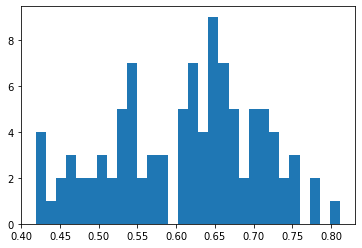

Val epoch 800, average corr 0.6118342234526974
Saving model...
Epoch: [801][10/101]	loss 2.270 (1.157)	image_p 0.936 (0.919)	gene_p 0.827 (0.930)
Epoch: [801][20/101]	loss 0.903 (1.016)	image_p 0.937 (0.925)	gene_p 0.927 (0.935)
Epoch: [801][30/101]	loss 0.729 (1.021)	image_p 0.905 (0.921)	gene_p 0.974 (0.933)
Epoch: [801][40/101]	loss 1.155 (1.036)	image_p 0.891 (0.917)	gene_p 0.944 (0.933)
Epoch: [801][50/101]	loss 0.651 (1.006)	image_p 0.969 (0.919)	gene_p 0.939 (0.930)
Epoch: [801][60/101]	loss 0.505 (0.984)	image_p 0.968 (0.919)	gene_p 0.971 (0.934)
Epoch: [801][70/101]	loss 0.222 (1.016)	image_p 0.986 (0.919)	gene_p 1.000 (0.933)
Epoch: [801][80/101]	loss 0.479 (1.002)	image_p 0.994 (0.920)	gene_p 0.950 (0.932)
Epoch: [801][90/101]	loss 0.930 (0.976)	image_p 0.940 (0.922)	gene_p 0.900 (0.932)
Epoch: [801][100/101]	loss 2.010 (1.008)	image_p 0.770 (0.919)	gene_p 0.890 (0.929)
Val epoch 801, average corr 0.6199814558557616
Epoch: [802][10/101]	loss 0.233 (0.609)	image_p 0.987 (0.95

Epoch: [810][40/101]	loss 0.172 (0.895)	image_p 1.000 (0.934)	gene_p 0.995 (0.933)
Epoch: [810][50/101]	loss 1.019 (0.916)	image_p 0.915 (0.932)	gene_p 0.906 (0.928)
Epoch: [810][60/101]	loss 0.147 (0.925)	image_p 1.000 (0.928)	gene_p 0.997 (0.929)
Epoch: [810][70/101]	loss 1.578 (0.960)	image_p 0.806 (0.924)	gene_p 0.946 (0.929)
Epoch: [810][80/101]	loss 1.777 (0.963)	image_p 0.809 (0.923)	gene_p 0.887 (0.927)
Epoch: [810][90/101]	loss 1.393 (0.951)	image_p 0.865 (0.925)	gene_p 0.918 (0.929)
Epoch: [810][100/101]	loss 0.682 (0.974)	image_p 0.949 (0.921)	gene_p 0.940 (0.926)
Val epoch 810, average corr 0.6215754409207235
Saving model...
Epoch: [811][10/101]	loss 0.620 (0.870)	image_p 0.991 (0.916)	gene_p 0.925 (0.945)
Epoch: [811][20/101]	loss 0.908 (0.929)	image_p 0.903 (0.922)	gene_p 0.915 (0.930)
Epoch: [811][30/101]	loss 0.956 (0.938)	image_p 0.963 (0.919)	gene_p 0.915 (0.932)
Epoch: [811][40/101]	loss 1.642 (0.921)	image_p 0.857 (0.923)	gene_p 0.876 (0.932)
Epoch: [811][50/101]	lo

Epoch: [819][80/101]	loss 0.215 (0.976)	image_p 0.991 (0.925)	gene_p 1.000 (0.929)
Epoch: [819][90/101]	loss 0.891 (1.017)	image_p 0.946 (0.921)	gene_p 0.921 (0.926)
Epoch: [819][100/101]	loss 0.454 (0.993)	image_p 0.946 (0.924)	gene_p 0.993 (0.928)
Val epoch 819, average corr 0.6133425520729853
Epoch: [820][10/101]	loss 0.706 (0.867)	image_p 0.938 (0.925)	gene_p 0.949 (0.944)
Epoch: [820][20/101]	loss 1.773 (0.954)	image_p 0.876 (0.918)	gene_p 0.821 (0.932)
Epoch: [820][30/101]	loss 0.353 (0.922)	image_p 0.998 (0.920)	gene_p 0.951 (0.937)
Epoch: [820][40/101]	loss 0.527 (0.931)	image_p 0.954 (0.923)	gene_p 0.981 (0.934)
Epoch: [820][50/101]	loss 0.449 (0.952)	image_p 0.956 (0.922)	gene_p 0.999 (0.932)
Epoch: [820][60/101]	loss 0.628 (0.969)	image_p 0.973 (0.919)	gene_p 0.923 (0.933)
Epoch: [820][70/101]	loss 0.647 (0.991)	image_p 0.947 (0.917)	gene_p 0.974 (0.931)
Epoch: [820][80/101]	loss 0.712 (0.998)	image_p 0.925 (0.917)	gene_p 0.975 (0.931)
Epoch: [820][90/101]	loss 0.608 (0.967)

Epoch: [829][10/101]	loss 1.155 (0.987)	image_p 0.890 (0.914)	gene_p 0.920 (0.925)
Epoch: [829][20/101]	loss 0.989 (1.079)	image_p 0.919 (0.907)	gene_p 0.913 (0.925)
Epoch: [829][30/101]	loss 1.102 (1.101)	image_p 0.878 (0.908)	gene_p 0.890 (0.924)
Epoch: [829][40/101]	loss 1.362 (1.133)	image_p 0.876 (0.903)	gene_p 0.878 (0.920)
Epoch: [829][50/101]	loss 1.239 (1.120)	image_p 0.910 (0.909)	gene_p 0.854 (0.917)
Epoch: [829][60/101]	loss 0.447 (1.096)	image_p 0.974 (0.914)	gene_p 0.962 (0.917)
Epoch: [829][70/101]	loss 0.534 (1.079)	image_p 0.978 (0.917)	gene_p 0.954 (0.919)
Epoch: [829][80/101]	loss 0.426 (1.095)	image_p 0.961 (0.917)	gene_p 1.000 (0.919)
Epoch: [829][90/101]	loss 0.847 (1.076)	image_p 0.941 (0.916)	gene_p 0.931 (0.921)
Epoch: [829][100/101]	loss 0.967 (1.064)	image_p 0.867 (0.915)	gene_p 0.974 (0.924)
Val epoch 829, average corr 0.6102510244001621
Epoch: [830][10/101]	loss 2.122 (1.069)	image_p 0.831 (0.905)	gene_p 0.849 (0.929)
Epoch: [830][20/101]	loss 0.362 (1.183)

Epoch: [838][50/101]	loss 0.606 (0.928)	image_p 0.933 (0.925)	gene_p 0.961 (0.934)
Epoch: [838][60/101]	loss 1.237 (0.909)	image_p 0.942 (0.927)	gene_p 0.923 (0.936)
Epoch: [838][70/101]	loss 0.950 (0.900)	image_p 0.877 (0.928)	gene_p 0.998 (0.934)
Epoch: [838][80/101]	loss 0.906 (0.924)	image_p 0.900 (0.926)	gene_p 0.945 (0.933)
Epoch: [838][90/101]	loss 0.232 (0.932)	image_p 1.000 (0.926)	gene_p 0.982 (0.932)
Epoch: [838][100/101]	loss 1.152 (0.940)	image_p 0.911 (0.926)	gene_p 0.879 (0.929)
Val epoch 838, average corr 0.6130046845509087
Epoch: [839][10/101]	loss 0.376 (0.906)	image_p 0.973 (0.924)	gene_p 0.975 (0.948)
Epoch: [839][20/101]	loss 0.510 (1.010)	image_p 0.986 (0.920)	gene_p 0.937 (0.925)
Epoch: [839][30/101]	loss 0.903 (1.025)	image_p 0.942 (0.924)	gene_p 0.925 (0.929)
Epoch: [839][40/101]	loss 0.935 (1.003)	image_p 0.870 (0.916)	gene_p 0.967 (0.935)
Epoch: [839][50/101]	loss 1.825 (0.982)	image_p 0.921 (0.920)	gene_p 0.811 (0.934)
Epoch: [839][60/101]	loss 0.940 (0.969)

Epoch: [847][90/101]	loss 1.182 (0.936)	image_p 0.894 (0.916)	gene_p 0.903 (0.941)
Epoch: [847][100/101]	loss 1.915 (0.932)	image_p 0.921 (0.918)	gene_p 0.876 (0.941)
Val epoch 847, average corr 0.5967738950549416
Epoch: [848][10/101]	loss 0.721 (0.928)	image_p 0.921 (0.917)	gene_p 0.975 (0.936)
Epoch: [848][20/101]	loss 0.496 (0.981)	image_p 0.980 (0.927)	gene_p 0.940 (0.928)
Epoch: [848][30/101]	loss 1.681 (0.980)	image_p 0.850 (0.922)	gene_p 0.863 (0.929)
Epoch: [848][40/101]	loss 0.557 (0.980)	image_p 0.952 (0.924)	gene_p 0.973 (0.928)
Epoch: [848][50/101]	loss 0.639 (0.975)	image_p 0.924 (0.923)	gene_p 0.974 (0.928)
Epoch: [848][60/101]	loss 0.937 (0.980)	image_p 1.000 (0.924)	gene_p 0.881 (0.928)
Epoch: [848][70/101]	loss 0.426 (0.961)	image_p 0.943 (0.923)	gene_p 0.996 (0.930)
Epoch: [848][80/101]	loss 0.647 (0.956)	image_p 0.935 (0.923)	gene_p 0.992 (0.932)
Epoch: [848][90/101]	loss 0.822 (0.991)	image_p 0.952 (0.920)	gene_p 0.926 (0.930)
Epoch: [848][100/101]	loss 1.807 (1.007

Epoch: [857][20/101]	loss 0.655 (1.057)	image_p 0.931 (0.915)	gene_p 0.973 (0.926)
Epoch: [857][30/101]	loss 1.827 (1.020)	image_p 0.860 (0.915)	gene_p 0.895 (0.932)
Epoch: [857][40/101]	loss 1.816 (1.008)	image_p 0.783 (0.915)	gene_p 0.905 (0.933)
Epoch: [857][50/101]	loss 0.455 (0.988)	image_p 0.998 (0.915)	gene_p 0.947 (0.934)
Epoch: [857][60/101]	loss 0.463 (0.993)	image_p 0.971 (0.911)	gene_p 0.971 (0.936)
Epoch: [857][70/101]	loss 0.672 (1.003)	image_p 0.974 (0.912)	gene_p 0.949 (0.935)
Epoch: [857][80/101]	loss 0.613 (1.016)	image_p 0.948 (0.909)	gene_p 0.966 (0.935)
Epoch: [857][90/101]	loss 0.942 (1.034)	image_p 0.914 (0.906)	gene_p 0.924 (0.934)
Epoch: [857][100/101]	loss 0.175 (1.014)	image_p 0.994 (0.909)	gene_p 1.000 (0.935)
Val epoch 857, average corr 0.607978876388065
Epoch: [858][10/101]	loss 0.540 (0.915)	image_p 0.950 (0.925)	gene_p 0.951 (0.926)
Epoch: [858][20/101]	loss 0.954 (0.962)	image_p 0.925 (0.921)	gene_p 0.966 (0.928)
Epoch: [858][30/101]	loss 0.739 (1.028)	

Epoch: [866][60/101]	loss 3.056 (0.885)	image_p 0.808 (0.928)	gene_p 0.769 (0.938)
Epoch: [866][70/101]	loss 0.998 (0.880)	image_p 0.909 (0.930)	gene_p 0.941 (0.936)
Epoch: [866][80/101]	loss 0.495 (0.895)	image_p 0.950 (0.927)	gene_p 0.975 (0.937)
Epoch: [866][90/101]	loss 1.317 (0.900)	image_p 0.910 (0.927)	gene_p 0.876 (0.937)
Epoch: [866][100/101]	loss 0.877 (0.879)	image_p 0.917 (0.928)	gene_p 0.951 (0.938)
Val epoch 866, average corr 0.603611478699702
Epoch: [867][10/101]	loss 1.796 (1.190)	image_p 0.791 (0.914)	gene_p 0.897 (0.909)
Epoch: [867][20/101]	loss 0.624 (1.034)	image_p 0.992 (0.918)	gene_p 0.917 (0.929)
Epoch: [867][30/101]	loss 1.156 (0.964)	image_p 0.945 (0.924)	gene_p 0.855 (0.931)
Epoch: [867][40/101]	loss 0.289 (0.931)	image_p 0.998 (0.925)	gene_p 0.980 (0.935)
Epoch: [867][50/101]	loss 0.625 (0.914)	image_p 0.930 (0.928)	gene_p 0.967 (0.934)
Epoch: [867][60/101]	loss 0.634 (0.883)	image_p 0.940 (0.930)	gene_p 0.968 (0.937)
Epoch: [867][70/101]	loss 0.238 (0.857)	

Epoch: [875][100/101]	loss 1.009 (0.914)	image_p 0.878 (0.928)	gene_p 0.974 (0.938)
Val epoch 875, average corr 0.62321395167395
Epoch: [876][10/101]	loss 1.808 (0.886)	image_p 0.934 (0.947)	gene_p 0.824 (0.928)
Epoch: [876][20/101]	loss 1.623 (0.931)	image_p 0.873 (0.941)	gene_p 0.864 (0.926)
Epoch: [876][30/101]	loss 0.801 (0.879)	image_p 0.968 (0.941)	gene_p 0.907 (0.929)
Epoch: [876][40/101]	loss 0.821 (0.877)	image_p 0.937 (0.937)	gene_p 0.941 (0.930)
Epoch: [876][50/101]	loss 0.674 (0.858)	image_p 0.917 (0.939)	gene_p 0.989 (0.932)
Epoch: [876][60/101]	loss 1.372 (0.919)	image_p 0.903 (0.937)	gene_p 0.870 (0.924)
Epoch: [876][70/101]	loss 0.854 (0.935)	image_p 0.931 (0.933)	gene_p 0.928 (0.923)
Epoch: [876][80/101]	loss 1.939 (0.943)	image_p 0.757 (0.931)	gene_p 0.902 (0.923)
Epoch: [876][90/101]	loss 1.491 (0.943)	image_p 0.916 (0.930)	gene_p 0.813 (0.924)
Epoch: [876][100/101]	loss 0.824 (0.951)	image_p 0.879 (0.927)	gene_p 0.999 (0.926)
Val epoch 876, average corr 0.6123274131

Epoch: [885][30/101]	loss 0.708 (0.835)	image_p 0.961 (0.934)	gene_p 0.918 (0.943)
Epoch: [885][40/101]	loss 0.871 (0.806)	image_p 0.898 (0.933)	gene_p 0.949 (0.946)
Epoch: [885][50/101]	loss 0.234 (0.780)	image_p 0.998 (0.937)	gene_p 0.992 (0.948)
Epoch: [885][60/101]	loss 0.583 (0.754)	image_p 0.947 (0.939)	gene_p 0.990 (0.949)
Epoch: [885][70/101]	loss 0.676 (0.789)	image_p 0.974 (0.937)	gene_p 0.917 (0.945)
Epoch: [885][80/101]	loss 1.457 (0.820)	image_p 0.954 (0.935)	gene_p 0.872 (0.944)
Epoch: [885][90/101]	loss 1.351 (0.837)	image_p 0.901 (0.933)	gene_p 0.888 (0.944)
Epoch: [885][100/101]	loss 0.699 (0.843)	image_p 0.950 (0.933)	gene_p 0.935 (0.944)
Val epoch 885, average corr 0.6065278719010784
Epoch: [886][10/101]	loss 0.877 (0.997)	image_p 0.880 (0.928)	gene_p 0.958 (0.926)
Epoch: [886][20/101]	loss 1.180 (0.978)	image_p 0.937 (0.933)	gene_p 0.829 (0.919)
Epoch: [886][30/101]	loss 0.144 (0.986)	image_p 0.997 (0.928)	gene_p 1.000 (0.923)
Epoch: [886][40/101]	loss 1.075 (0.930)

Epoch: [894][70/101]	loss 1.656 (0.951)	image_p 0.916 (0.920)	gene_p 0.874 (0.931)
Epoch: [894][80/101]	loss 1.273 (0.943)	image_p 0.933 (0.920)	gene_p 0.817 (0.930)
Epoch: [894][90/101]	loss 1.676 (0.938)	image_p 0.844 (0.923)	gene_p 0.965 (0.930)
Epoch: [894][100/101]	loss 0.574 (0.950)	image_p 0.978 (0.922)	gene_p 0.946 (0.929)
Val epoch 894, average corr 0.6092854604159841
Epoch: [895][10/101]	loss 0.596 (1.037)	image_p 0.925 (0.926)	gene_p 0.975 (0.933)
Epoch: [895][20/101]	loss 0.996 (0.909)	image_p 0.917 (0.922)	gene_p 0.926 (0.948)
Epoch: [895][30/101]	loss 1.170 (0.901)	image_p 0.920 (0.920)	gene_p 0.905 (0.946)
Epoch: [895][40/101]	loss 0.547 (0.895)	image_p 0.971 (0.920)	gene_p 0.963 (0.946)
Epoch: [895][50/101]	loss 1.202 (0.893)	image_p 0.922 (0.921)	gene_p 0.900 (0.945)
Epoch: [895][60/101]	loss 1.145 (0.895)	image_p 0.878 (0.922)	gene_p 0.924 (0.944)
Epoch: [895][70/101]	loss 0.258 (0.867)	image_p 0.995 (0.925)	gene_p 0.991 (0.944)
Epoch: [895][80/101]	loss 0.363 (0.874)

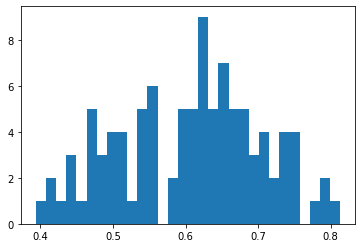

Val epoch 900, average corr 0.6059762068794214
Saving model...
Epoch: [901][10/101]	loss 1.770 (0.821)	image_p 0.834 (0.936)	gene_p 0.886 (0.935)
Epoch: [901][20/101]	loss 1.309 (0.887)	image_p 0.855 (0.921)	gene_p 0.911 (0.937)
Epoch: [901][30/101]	loss 0.344 (0.924)	image_p 0.999 (0.923)	gene_p 0.967 (0.932)
Epoch: [901][40/101]	loss 1.153 (1.027)	image_p 0.921 (0.914)	gene_p 0.936 (0.928)
Epoch: [901][50/101]	loss 1.271 (0.986)	image_p 0.830 (0.916)	gene_p 0.948 (0.932)
Epoch: [901][60/101]	loss 0.200 (0.941)	image_p 0.999 (0.918)	gene_p 0.994 (0.936)
Epoch: [901][70/101]	loss 1.014 (0.908)	image_p 0.915 (0.922)	gene_p 0.942 (0.939)
Epoch: [901][80/101]	loss 0.842 (0.898)	image_p 0.994 (0.924)	gene_p 0.874 (0.938)
Epoch: [901][90/101]	loss 0.283 (0.890)	image_p 0.998 (0.924)	gene_p 0.980 (0.940)
Epoch: [901][100/101]	loss 0.779 (0.889)	image_p 0.961 (0.925)	gene_p 0.947 (0.939)
Val epoch 901, average corr 0.5986843990278041
Epoch: [902][10/101]	loss 1.606 (1.189)	image_p 0.831 (0.89

Epoch: [910][40/101]	loss 0.916 (0.843)	image_p 0.900 (0.933)	gene_p 0.959 (0.939)
Epoch: [910][50/101]	loss 0.783 (0.830)	image_p 0.964 (0.935)	gene_p 0.898 (0.940)
Epoch: [910][60/101]	loss 0.636 (0.811)	image_p 0.974 (0.936)	gene_p 0.921 (0.942)
Epoch: [910][70/101]	loss 0.250 (0.799)	image_p 0.998 (0.935)	gene_p 0.983 (0.943)
Epoch: [910][80/101]	loss 0.943 (0.795)	image_p 0.924 (0.935)	gene_p 0.925 (0.943)
Epoch: [910][90/101]	loss 0.300 (0.785)	image_p 0.998 (0.935)	gene_p 0.980 (0.946)
Epoch: [910][100/101]	loss 1.361 (0.777)	image_p 0.903 (0.936)	gene_p 0.914 (0.946)
Val epoch 910, average corr 0.5897110033580417
Saving model...
Epoch: [911][10/101]	loss 0.761 (0.806)	image_p 0.940 (0.944)	gene_p 0.934 (0.932)
Epoch: [911][20/101]	loss 0.311 (0.854)	image_p 0.959 (0.936)	gene_p 0.997 (0.933)
Epoch: [911][30/101]	loss 1.367 (0.907)	image_p 0.815 (0.930)	gene_p 0.947 (0.927)
Epoch: [911][40/101]	loss 0.851 (0.940)	image_p 0.923 (0.927)	gene_p 0.943 (0.926)
Epoch: [911][50/101]	lo

Epoch: [919][80/101]	loss 0.764 (0.855)	image_p 0.931 (0.929)	gene_p 0.938 (0.940)
Epoch: [919][90/101]	loss 0.592 (0.840)	image_p 0.921 (0.931)	gene_p 0.991 (0.941)
Epoch: [919][100/101]	loss 0.677 (0.862)	image_p 0.930 (0.927)	gene_p 0.973 (0.940)
Val epoch 919, average corr 0.5994564841033947
Epoch: [920][10/101]	loss 0.283 (0.531)	image_p 0.993 (0.959)	gene_p 0.989 (0.968)
Epoch: [920][20/101]	loss 1.103 (0.750)	image_p 0.950 (0.940)	gene_p 0.922 (0.952)
Epoch: [920][30/101]	loss 0.699 (0.771)	image_p 0.949 (0.941)	gene_p 0.992 (0.949)
Epoch: [920][40/101]	loss 0.490 (0.789)	image_p 0.954 (0.939)	gene_p 0.975 (0.948)
Epoch: [920][50/101]	loss 0.493 (0.846)	image_p 0.981 (0.933)	gene_p 0.957 (0.944)
Epoch: [920][60/101]	loss 0.593 (0.837)	image_p 0.934 (0.934)	gene_p 0.975 (0.942)
Epoch: [920][70/101]	loss 0.913 (0.859)	image_p 0.919 (0.931)	gene_p 0.942 (0.941)
Epoch: [920][80/101]	loss 1.151 (0.886)	image_p 0.937 (0.930)	gene_p 0.908 (0.939)
Epoch: [920][90/101]	loss 0.697 (0.863)

Epoch: [929][10/101]	loss 0.399 (0.924)	image_p 0.984 (0.936)	gene_p 0.953 (0.931)
Epoch: [929][20/101]	loss 1.189 (0.903)	image_p 0.879 (0.928)	gene_p 0.881 (0.933)
Epoch: [929][30/101]	loss 0.494 (0.829)	image_p 0.975 (0.931)	gene_p 0.940 (0.942)
Epoch: [929][40/101]	loss 0.653 (0.836)	image_p 0.960 (0.926)	gene_p 0.963 (0.945)
Epoch: [929][50/101]	loss 0.370 (0.797)	image_p 0.999 (0.930)	gene_p 0.953 (0.947)
Epoch: [929][60/101]	loss 1.919 (0.803)	image_p 0.833 (0.931)	gene_p 0.819 (0.945)
Epoch: [929][70/101]	loss 0.605 (0.839)	image_p 0.970 (0.930)	gene_p 0.909 (0.942)
Epoch: [929][80/101]	loss 1.028 (0.823)	image_p 0.900 (0.931)	gene_p 0.932 (0.944)
Epoch: [929][90/101]	loss 0.709 (0.831)	image_p 0.943 (0.931)	gene_p 0.947 (0.943)
Epoch: [929][100/101]	loss 0.118 (0.803)	image_p 0.999 (0.933)	gene_p 0.999 (0.946)
Val epoch 929, average corr 0.591518877306646
Epoch: [930][10/101]	loss 1.233 (0.826)	image_p 0.885 (0.927)	gene_p 0.883 (0.947)
Epoch: [930][20/101]	loss 0.905 (0.898)	

Epoch: [938][50/101]	loss 0.652 (0.762)	image_p 0.926 (0.937)	gene_p 0.997 (0.950)
Epoch: [938][60/101]	loss 1.076 (0.806)	image_p 0.921 (0.935)	gene_p 0.898 (0.944)
Epoch: [938][70/101]	loss 0.791 (0.817)	image_p 0.945 (0.934)	gene_p 0.933 (0.942)
Epoch: [938][80/101]	loss 0.779 (0.821)	image_p 0.931 (0.932)	gene_p 0.983 (0.943)
Epoch: [938][90/101]	loss 0.656 (0.804)	image_p 0.920 (0.934)	gene_p 0.986 (0.945)
Epoch: [938][100/101]	loss 1.073 (0.794)	image_p 0.881 (0.934)	gene_p 0.947 (0.946)
Val epoch 938, average corr 0.5985842729130673
Epoch: [939][10/101]	loss 1.003 (0.902)	image_p 0.905 (0.922)	gene_p 0.929 (0.934)
Epoch: [939][20/101]	loss 0.932 (0.991)	image_p 0.906 (0.921)	gene_p 0.951 (0.931)
Epoch: [939][30/101]	loss 0.966 (0.953)	image_p 0.947 (0.923)	gene_p 0.887 (0.938)
Epoch: [939][40/101]	loss 0.614 (0.908)	image_p 0.949 (0.928)	gene_p 0.949 (0.940)
Epoch: [939][50/101]	loss 1.067 (0.941)	image_p 0.896 (0.922)	gene_p 0.943 (0.939)
Epoch: [939][60/101]	loss 1.065 (0.932)

Epoch: [947][90/101]	loss 0.665 (0.833)	image_p 0.985 (0.933)	gene_p 0.917 (0.942)
Epoch: [947][100/101]	loss 1.348 (0.852)	image_p 0.892 (0.931)	gene_p 0.861 (0.941)
Val epoch 947, average corr 0.5960239215344427
Epoch: [948][10/101]	loss 0.709 (0.828)	image_p 0.949 (0.947)	gene_p 0.938 (0.929)
Epoch: [948][20/101]	loss 1.166 (0.804)	image_p 0.910 (0.937)	gene_p 0.861 (0.936)
Epoch: [948][30/101]	loss 0.648 (0.832)	image_p 0.926 (0.939)	gene_p 0.974 (0.928)
Epoch: [948][40/101]	loss 0.551 (0.863)	image_p 0.947 (0.932)	gene_p 0.972 (0.931)
Epoch: [948][50/101]	loss 0.674 (0.853)	image_p 0.974 (0.932)	gene_p 0.925 (0.932)
Epoch: [948][60/101]	loss 0.152 (0.813)	image_p 0.997 (0.937)	gene_p 1.000 (0.936)
Epoch: [948][70/101]	loss 1.406 (0.835)	image_p 0.870 (0.932)	gene_p 0.884 (0.937)
Epoch: [948][80/101]	loss 1.166 (0.846)	image_p 0.920 (0.931)	gene_p 0.899 (0.937)
Epoch: [948][90/101]	loss 0.514 (0.850)	image_p 0.939 (0.931)	gene_p 0.995 (0.938)
Epoch: [948][100/101]	loss 1.085 (0.852

Epoch: [957][20/101]	loss 0.520 (0.869)	image_p 0.974 (0.933)	gene_p 0.952 (0.944)
Epoch: [957][30/101]	loss 0.390 (0.810)	image_p 0.966 (0.942)	gene_p 0.998 (0.947)
Epoch: [957][40/101]	loss 0.494 (0.817)	image_p 0.964 (0.934)	gene_p 0.972 (0.949)
Epoch: [957][50/101]	loss 0.571 (0.841)	image_p 0.934 (0.930)	gene_p 0.973 (0.946)
Epoch: [957][60/101]	loss 1.171 (0.869)	image_p 0.878 (0.930)	gene_p 0.909 (0.941)
Epoch: [957][70/101]	loss 0.261 (0.861)	image_p 0.979 (0.929)	gene_p 0.998 (0.943)
Epoch: [957][80/101]	loss 1.456 (0.878)	image_p 0.904 (0.927)	gene_p 0.949 (0.944)
Epoch: [957][90/101]	loss 0.322 (0.895)	image_p 0.985 (0.926)	gene_p 0.976 (0.945)
Epoch: [957][100/101]	loss 0.829 (0.874)	image_p 0.901 (0.927)	gene_p 0.949 (0.946)
Val epoch 957, average corr 0.5989053252385734
Epoch: [958][10/101]	loss 0.451 (0.544)	image_p 0.982 (0.964)	gene_p 0.966 (0.959)
Epoch: [958][20/101]	loss 1.062 (0.729)	image_p 0.920 (0.940)	gene_p 0.864 (0.950)
Epoch: [958][30/101]	loss 1.509 (0.805)

Epoch: [966][60/101]	loss 1.113 (0.837)	image_p 0.915 (0.925)	gene_p 0.917 (0.948)
Epoch: [966][70/101]	loss 0.950 (0.865)	image_p 0.906 (0.920)	gene_p 0.929 (0.947)
Epoch: [966][80/101]	loss 0.896 (0.861)	image_p 0.899 (0.919)	gene_p 0.946 (0.948)
Epoch: [966][90/101]	loss 2.089 (0.886)	image_p 0.777 (0.916)	gene_p 0.872 (0.946)
Epoch: [966][100/101]	loss 1.784 (0.888)	image_p 0.911 (0.918)	gene_p 0.924 (0.945)
Val epoch 966, average corr 0.6062685256657535
Epoch: [967][10/101]	loss 0.758 (0.979)	image_p 0.924 (0.912)	gene_p 0.971 (0.934)
Epoch: [967][20/101]	loss 0.361 (0.928)	image_p 0.956 (0.932)	gene_p 0.992 (0.938)
Epoch: [967][30/101]	loss 1.273 (0.942)	image_p 0.927 (0.930)	gene_p 0.916 (0.936)
Epoch: [967][40/101]	loss 0.536 (0.924)	image_p 0.946 (0.932)	gene_p 0.975 (0.937)
Epoch: [967][50/101]	loss 0.122 (0.856)	image_p 0.999 (0.937)	gene_p 1.000 (0.941)
Epoch: [967][60/101]	loss 0.948 (0.845)	image_p 0.967 (0.938)	gene_p 0.870 (0.939)
Epoch: [967][70/101]	loss 1.483 (0.840)

Epoch: [975][100/101]	loss 1.228 (0.846)	image_p 0.907 (0.932)	gene_p 0.902 (0.941)
Val epoch 975, average corr 0.5948409511353776
Epoch: [976][10/101]	loss 1.206 (1.036)	image_p 0.852 (0.908)	gene_p 0.917 (0.930)
Epoch: [976][20/101]	loss 0.601 (0.937)	image_p 0.977 (0.916)	gene_p 0.945 (0.934)
Epoch: [976][30/101]	loss 1.067 (0.913)	image_p 0.932 (0.919)	gene_p 0.894 (0.934)
Epoch: [976][40/101]	loss 1.021 (1.004)	image_p 0.908 (0.912)	gene_p 0.930 (0.928)
Epoch: [976][50/101]	loss 1.450 (1.010)	image_p 0.926 (0.913)	gene_p 0.918 (0.931)
Epoch: [976][60/101]	loss 0.699 (0.977)	image_p 0.946 (0.918)	gene_p 0.947 (0.931)
Epoch: [976][70/101]	loss 1.222 (0.980)	image_p 0.883 (0.918)	gene_p 0.900 (0.929)
Epoch: [976][80/101]	loss 0.580 (0.956)	image_p 0.953 (0.920)	gene_p 0.941 (0.931)
Epoch: [976][90/101]	loss 1.241 (0.939)	image_p 0.865 (0.922)	gene_p 0.890 (0.933)
Epoch: [976][100/101]	loss 0.906 (0.927)	image_p 0.907 (0.922)	gene_p 0.948 (0.934)
Val epoch 976, average corr 0.60486049

Epoch: [985][30/101]	loss 0.568 (0.767)	image_p 1.000 (0.936)	gene_p 0.893 (0.938)
Epoch: [985][40/101]	loss 0.588 (0.784)	image_p 0.972 (0.935)	gene_p 0.941 (0.938)
Epoch: [985][50/101]	loss 0.418 (0.798)	image_p 0.972 (0.935)	gene_p 0.973 (0.941)
Epoch: [985][60/101]	loss 0.723 (0.809)	image_p 0.950 (0.934)	gene_p 0.939 (0.939)
Epoch: [985][70/101]	loss 0.853 (0.806)	image_p 0.928 (0.935)	gene_p 0.906 (0.939)
Epoch: [985][80/101]	loss 1.224 (0.812)	image_p 0.862 (0.933)	gene_p 0.926 (0.939)
Epoch: [985][90/101]	loss 0.887 (0.830)	image_p 0.943 (0.931)	gene_p 0.911 (0.938)
Epoch: [985][100/101]	loss 1.042 (0.835)	image_p 0.904 (0.930)	gene_p 0.919 (0.938)
Val epoch 985, average corr 0.5993866944490531
Epoch: [986][10/101]	loss 1.487 (1.019)	image_p 0.876 (0.913)	gene_p 0.928 (0.937)
Epoch: [986][20/101]	loss 0.307 (0.811)	image_p 0.989 (0.936)	gene_p 0.997 (0.945)
Epoch: [986][30/101]	loss 1.117 (0.832)	image_p 0.892 (0.934)	gene_p 0.907 (0.942)
Epoch: [986][40/101]	loss 0.647 (0.800)

Epoch: [994][70/101]	loss 0.254 (0.816)	image_p 0.997 (0.931)	gene_p 0.983 (0.944)
Epoch: [994][80/101]	loss 1.649 (0.854)	image_p 0.898 (0.931)	gene_p 0.846 (0.943)
Epoch: [994][90/101]	loss 0.284 (0.830)	image_p 0.974 (0.932)	gene_p 0.999 (0.946)
Epoch: [994][100/101]	loss 0.566 (0.838)	image_p 0.927 (0.932)	gene_p 0.972 (0.945)
Val epoch 994, average corr 0.5943406051198703
Epoch: [995][10/101]	loss 0.448 (0.592)	image_p 0.971 (0.963)	gene_p 0.972 (0.948)
Epoch: [995][20/101]	loss 0.570 (0.698)	image_p 0.945 (0.952)	gene_p 0.975 (0.944)
Epoch: [995][30/101]	loss 0.816 (0.761)	image_p 0.931 (0.942)	gene_p 0.948 (0.946)
Epoch: [995][40/101]	loss 1.007 (0.802)	image_p 0.876 (0.940)	gene_p 0.940 (0.941)
Epoch: [995][50/101]	loss 0.639 (0.834)	image_p 0.947 (0.938)	gene_p 0.950 (0.936)
Epoch: [995][60/101]	loss 0.999 (0.833)	image_p 0.968 (0.937)	gene_p 0.874 (0.936)
Epoch: [995][70/101]	loss 0.529 (0.828)	image_p 0.974 (0.937)	gene_p 0.950 (0.936)
Epoch: [995][80/101]	loss 1.181 (0.833)

In [25]:
for epoch in range(n_epoch+1, 1000):
    loss, image_loss, image_prob, gene_loss, gene_prob = \
        train(epoch, train_loader, model, contrast, criterion_image, criterion_gene, optimizer, 
              gradient_clip=gradient_clip, print_freq=10, device=device)
    hist['loss'].append(loss)
    hist['image_loss'].append(image_loss)
    hist['image_prob'].append(image_prob)
    hist['gene_loss'].append(gene_loss)
    hist['gene_prob'].append(gene_prob)
    
    corr = test(epoch, test_loader, model, contrast, criterion_image, criterion_gene, optimizer, 
              gradient_clip=gradient_clip, print_freq=10, device=device)
    hist['corr_val'].append(corr)
    
    # Save model
    if epoch % save_freq == 0 and epoch != 0:
        print("Saving model...")
        state = { 'model': model.state_dict(),
                  'contrast': contrast.state_dict(),
                  'optimizer': optimizer.state_dict(),
                  'epoch': epoch}
        torch.save(state, os.path.join(model_dir, "epoch_{}.pt".format(epoch)))

torch.save(hist, os.path.join(model_dir, "hist.pt"))

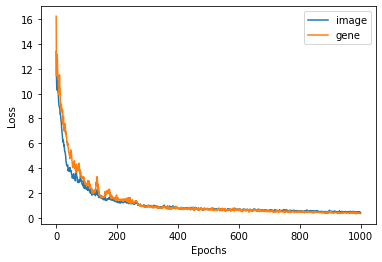

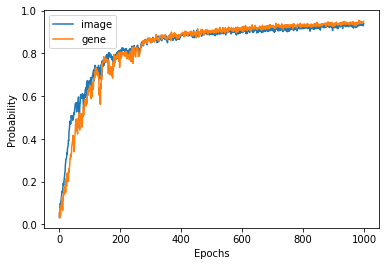

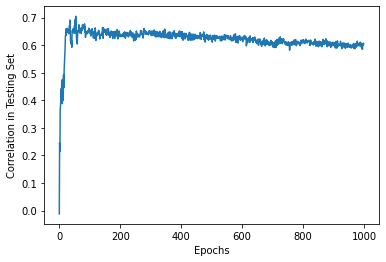

In [26]:
plt.plot(np.arange(len(hist['image_loss'])), hist['image_loss'])
plt.plot(np.arange(len(hist['gene_loss'])), hist['gene_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["image", "gene"])
plt.show()
plt.plot(np.arange(len(hist['image_prob'])), hist['image_prob'])
plt.plot(np.arange(len(hist['gene_prob'])), hist['gene_prob'])
plt.xlabel("Epochs")
plt.ylabel("Probability")
plt.legend(["image", "gene"])
plt.show()
plt.plot(hist['corr_val'])
plt.xlabel("Epochs")
plt.ylabel("Correlation in Testing Set")
plt.show()

In [27]:
print("Saving model...")
state = { 'model': model.state_dict(),
          'contrast': contrast.state_dict(),
          'optimizer': optimizer.state_dict(),
          'epoch': epoch}
torch.save(state, os.path.join(model_dir, "epoch_{}.pt".format(epoch)))
torch.save(hist, os.path.join(model_dir, "hist_continue.pt"))

Saving model...


In [28]:
np.argmax(hist['corr_val'])

54

# Session Info

In [58]:
!pip freeze

absl-py==0.7.0
adjustText==0.7.3
altair==3.2.0
anndata==0.7.5
argh==0.26.2
ase==3.21.1
astor==0.7.1
astropy==3.2.1
atomicwrites==1.3.0
attrs==19.1.0
autograd==1.3
autograd-gamma==0.5.0
backcall==0.1.0
base58==1.0.3
bleach==1.5.0
blinker==1.4
boto3==1.10.15
botocore==1.13.15
Bottleneck==1.2.1
cachetools==4.1.0
certifi==2019.3.9
chardet==3.0.4
Click==7.0
cvxopt==1.2.3
cvxpy==1.0.24
cycler==0.10.0
Cython==0.29.15
dataclasses==0.8
decorator==4.4.0
defusedxml==0.5.0
dill==0.2.9
docutils==0.15.2
ecos==2.0.7.post1
entrypoints==0.3
enum-compat==0.0.3
environment-kernels==1.1.1
FITS-tools==0.2
formulaic==0.2.4
future==0.17.1
gast==0.2.2
get-version==2.1
google-auth==1.14.3
google-auth-oauthlib==0.4.1
google-pasta==0.2.0
googledrivedownloader==0.4
grpcio==1.29.0
h5py==2.10.0
html5lib==0.9999999
idna==2.8
image-registration==0.2.4
imageio==2.6.1
importlib-metadata==0.23
interface-meta==1.2.3
ipykernel==5.1.0
ipython==7.4.0
ipython-genutils==0.2.0
ipywidgets==7.4.2
isodate==0.6.0
jedi==0.13.3
Jinj